共享单车在2015年起开始在国内掀起热潮，大量资本涌入，一时间摩拜，ofo，HelloBike，小鸣单车，永安行等公司开启了中国互联网历史上的又一场市场大战，各色Logo的共享单车遍布街头，甚至堆积如山。这一盛况没有持续太久，烧钱之后，补贴过后，繁华褪去，大批共享单车公司倒下，如今共享单车的战局跟当年网约车大战类似，仅剩摩拜一家独大，不胜唏嘘。

共享单车早些年已经出现在美国，本文数据来自Kaggle的[Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/data)预测项目，由共享单车公司[Capital Bikeshare](https://en.wikipedia.org/wiki/Capital_Bikeshare)提供。数据统计了华盛顿特区2011年1月1日至2012年12月31日每个小时段内的共享单车租车量。数据集分为train.csv和test.csv，train.csv包含了这两年在每月1日至19日的租车数据，test.csv包含了每月20日至当月最后一天的天气和时间数据，租车数据需要项目参与者预测。由于本文不涉及机器学习部分，因此仅对train.csv数据进行数据可视化分析。

# 1. 提出问题

数据中各列标题如下：
* datetime时间 - 格式：年月日小时
* season季节 - 1 = spring春天, 2 = summer夏天, 3 = fall秋天, 4 = winter冬天
* holiday节假日 - 0：否，1：是
* workingday工作日 - 该天既不是周末也不是假日（0：否，1：是）
* weather天气 - 1:晴天/局部多云，2:多云/阴天/薄雾 ，3:小雨/小雪 ，4:恶劣天气（大雨、冰雹、暴风雨或者大雪）
* temp实际温度 - 摄氏度
* atemp体感温度 - 摄氏度
* humidity湿度 - 相对湿度
* windspeed风速 - 风速
* casual - 未注册用户租车数量
* registered - 注册用户租车数量
* count - 总租车数量

数据中有天气变量，时间变量，注册与非注册用户租车数量，因此可以提出如下问题：

1. 2011年至2012年共享单车的总体租借情况如何？
2. 租车量是否受季节因素影响？
3. 工作日，节假日的租车量有何不同？
4. 每天哪个时段的租车量较高？
5. 天气情况对租车量的影响如何？
6. 注册用户和非注册用户的租车量对比，用户习惯是否不同？

根据以上问题的分析，共享单车公司可以获取用户的租车习惯，影响租车量的变量，据此进行相应的市场推广和部署。

# 2. 理解数据
下面开始读取数据并尝试理解数据。

In [1]:
# 导入模块包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# 设定matplot高清作图
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 读取csv文件并查看前5行数据
df = pd.read_csv('train.csv', parse_dates=['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# 查看末5行数据
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [4]:
# 查看数据集信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


数据共有10886行12列，所有列都没有缺失值，因此可以略过缺失值填充过程。

In [5]:
# 查看数据集描述性统计
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


各列的描述性统计数据相对合理，无论是气温、湿度、风速还是租车量变量都没有明显的异常值，因此可以跳到数据清洗过程。

# 3. 数据清洗
由于时间数据仅存在datetime一列中，为了分析各个时段的租车数据，例如每个时间段，每天或者每月的数据，就需要将年月日时刻信息从datetime数据中提取出来，因此需要增加时间数据列。

## 3.1 增加时间数据列

In [6]:
# 保留原始数据df，新建df的副本进行数据清洗
data = df.copy()

In [7]:
# 导入dateutil模块帮助提取时间数据
from dateutil.parser import *

# 提取datetime数据，并将数据类型转换成str
date_time = data['datetime'].astype('str')

In [8]:
# 利用parse()解析时间数据
parsed = date_time.apply(lambda x: parse(x))

# 提取年、月、日、小时、星期日数，并以列的形式添加到data数据中
data['year'] = parsed.apply(lambda x: x.year)
data['month'] = parsed.apply(lambda x: x.month)
data['day'] = parsed.apply(lambda x: x.day)
data['hour'] = parsed.apply(lambda x: x.hour)
data['weekday'] = parsed.apply(lambda x: x.strftime("%w"))

In [9]:
# 查看列标题
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [10]:
# 调整列标题顺序，方便理解数据
columns = ['datetime', 'year', 'month', 'day', 'hour', 'weekday',
           'season', 'holiday', 'workingday', 
           'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
           'casual', 'registered', 'count',]

data = data[columns]

In [11]:
# 查看列顺序调整后的数据
data.head()

,datetime,year,month,day,hour,weekday,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,6,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,6,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,6,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,6,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,6,1,0,0,1,9.84,14.395,75,0.0,0,1,1


数据符合预期，下面使用`map()`函数做进一步的数据清洗。

## 3.2 数据类型转换

季节，节假日，工作日，星期日数等列数据目前都是`int`类型，为了便于进行数据可视化，可以使用`map()`和`pd.Categorical()`将这些列的数据转换成分类数据。例如季节数据`1`代表春天，可以将数值型数据`1`转换成文本型数据`Spring`，再转换成带顺序的分类型数据，这样在数据可视化时会自动保留`Spring`--`Summer`--`Fall`--`Winter`的季节顺序。对于一年中任意一天，它只能是工作日或者非工作日，其中非工作日又分为节假日和周末，因此，任意一天的日期类型只能是`workingday`，或者`weekend`，或者`holiday`，因此可以用一列由这三者组成的数据替代`workingday`和`holiday`两列的数据。

In [92]:
# 制作数据副本
bike_rental = data.copy()

In [93]:
# 将datetime列转换成行索引
bike_rental.set_index('datetime', inplace=True)

In [94]:
# 定义day_type函数，功能为判断日期类型
def day_type(row):
    # 节假日则返回2
    if row['holiday'] == 1:
        return 2
    
    # 非节假日但非工作日，即周末则返回1， 工作日返回0
    elif row['workingday'] == 0 and row['holiday'] == 0:
        return 1
    else:
        return 0

In [95]:
# 添加一列day_type，值为日期的日期类型
bike_rental['day_type'] = bike_rental.apply(day_type, axis=1)

原数据中是这样定义季节的：
- 春季：1-3月
- 夏季：4-6月
- 秋季：7-9月
- 冬季：10-12月

根据[气象学分法](https://zh.wikipedia.org/wiki/%E5%AD%A3%E8%8A%82#%E5%9B%9B%E5%AD%A3%E7%9A%84%E5%88%92%E5%88%86)以及普遍的认知，北半球更为合适的季节分法应该是：
- 春季：3-5月
- 夏季：6-8月
- 秋季：9-11月
- 冬季：12-次年2月

以下可以根据气温数据确认这一判断。

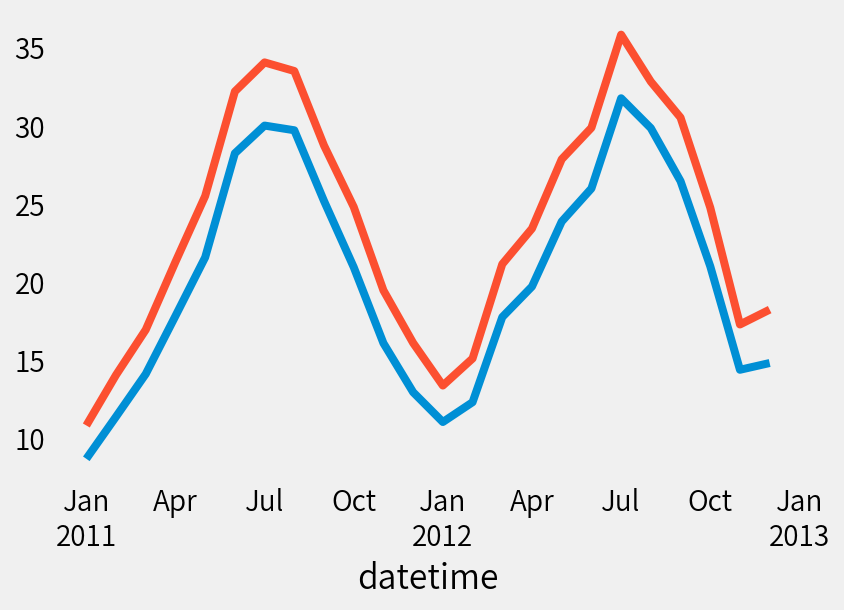

In [96]:
# 根据每月气温作图
bike_rental['temp'].resample('M').mean().plot()
bike_rental['atemp'].resample('M').mean().plot()
plt.grid(axis='both')

由上图，体感温度高于实际温度2-3度，月最低气温出现在12，1，2月，月最高气温出现在5，6，7，8月，季节特征符合北半球季节分法。因此接下来通过月份数据来转换季节。

In [97]:
# 使用map()函数转换数值为文本型
bike_rental['season'] = bike_rental['month'].map({12: '冬季', 1: '冬季', 2: '冬季',
                                                  3: '春季', 4: '春季', 5: '春季',
                                                  6: '夏季', 7: '夏季', 8: '夏季',
                                                  9: '秋季', 10: '秋季', 11: '秋季'})

bike_rental['day_type'] = bike_rental['day_type'].map({0: '工作日', 1: '周末', 2: '法定假日'})

bike_rental['weekday'] = bike_rental['weekday'].astype('int').map({0: '星期日', 1: '星期一', 2: '星期二', 3: '星期三',
                                                     4: '星期四', 5: '星期五', 6: '星期六'})

bike_rental['weather'] = bike_rental['weather'].astype('int').map({1: '晴朗/局部多云', 2: '多云/薄雾', 
                                                                   3: '小雨/小雪', 4: '大雨/大雪及其他'})

In [98]:
# 将文本型数据转换成带顺序的分类数据
bike_rental['season'] = pd.Categorical(values=bike_rental['season'], ordered=True, 
                                       categories=['春季', '夏季', '秋季', '冬季'])

bike_rental['day_type'] = pd.Categorical(values=bike_rental['day_type'], ordered=True, 
                                       categories=['工作日', '周末', '法定假日'])

bike_rental['weekday'] = pd.Categorical(values=bike_rental['weekday'], ordered=True, 
                                       categories=['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日'])

In [99]:
# 检视清洗后的数据确认清洗效果
bike_rental.head()

,year,month,day,hour,weekday,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_type
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,1,1,0,星期六,冬季,0,0,晴朗/局部多云,9.84,14.395,81,0.0,3,13,16,周末
2011-01-01 01:00:00,2011,1,1,1,星期六,冬季,0,0,晴朗/局部多云,9.02,13.635,80,0.0,8,32,40,周末
2011-01-01 02:00:00,2011,1,1,2,星期六,冬季,0,0,晴朗/局部多云,9.02,13.635,80,0.0,5,27,32,周末
2011-01-01 03:00:00,2011,1,1,3,星期六,冬季,0,0,晴朗/局部多云,9.84,14.395,75,0.0,3,10,13,周末
2011-01-01 04:00:00,2011,1,1,4,星期六,冬季,0,0,晴朗/局部多云,9.84,14.395,75,0.0,0,1,1,周末


# 4. 数据可视化

In [100]:
# 设置作图风格
plt.style.use('fivethirtyeight')

In [101]:
# 设置颜色组
c1 = (114/255,158/255,206/255) # 蓝
c2 = (255/255,158/255,74/255) # 橙
c3 = (103/255,191/255,92/255) # 绿
c4 = (237/255,102/255,93/255) # 红
c5 = (173/255,139/255,201/255) # 紫
c6 = (168/255,120/255,110/255) # 棕

## 4.1 2011年至2012年共享单车的总体租车情况

为了方便展示，统计每月的注册用户和非注册用户数据，以及注册用户所占的租车量比例。

In [102]:
# 统计每月的租车量数据
total = bike_rental[['casual', 'registered', 'count']].resample('M').sum().reset_index()

# 计算注册用户所占租车量比例
total['rate'] = total['registered'] / total['count']

# 将月份数据转换成文本型
total['month'] = total['datetime'].apply(lambda x: x.strftime('%m\n%Y') 
                                         if x.strftime('%m') == '01' else x.strftime('%m'))

> 注：strftime转换时间格式可参考[这里](http://www.runoob.com/python/att-time-strftime.html). 

Text(-1,-0.2,'制图：MilanKaka              数据：Kaggle')

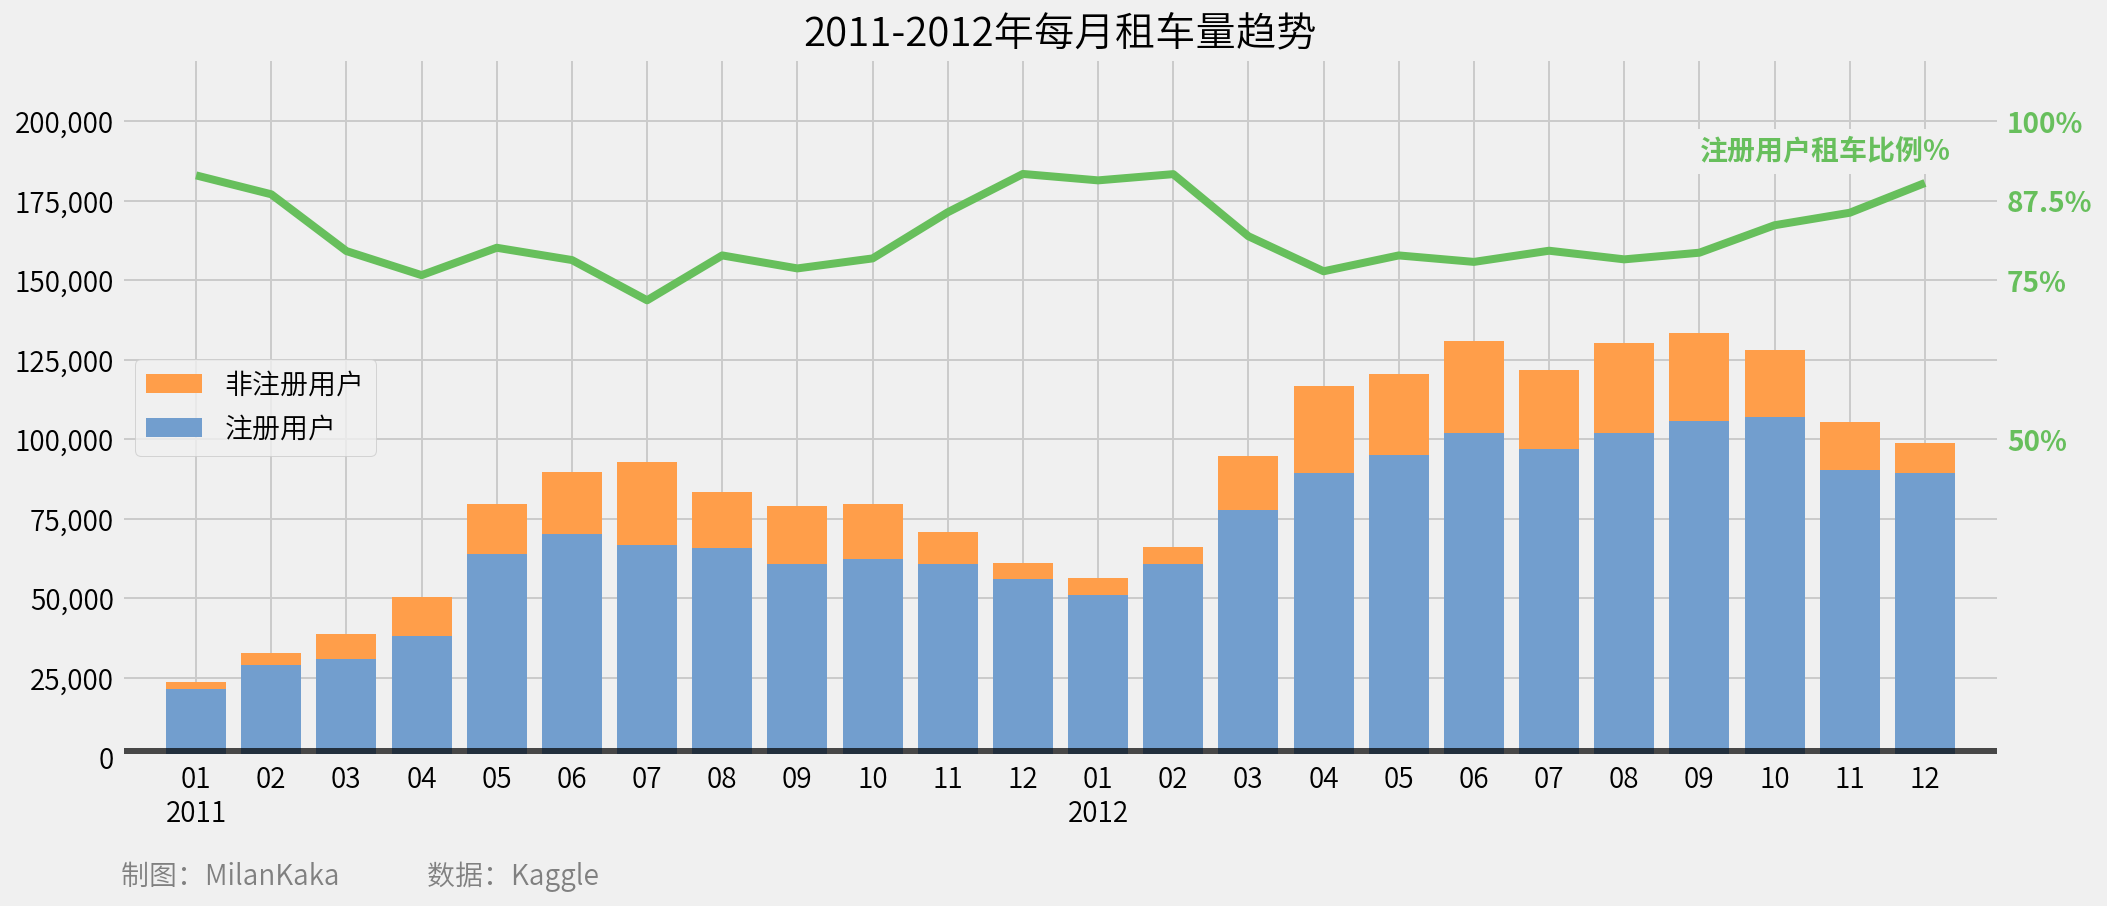

In [103]:
# 设定作图尺寸
fig, ax1 = plt.subplots(figsize=(15,6))

# 根据每月租车数量作图
ax1 = plt.bar(np.arange(24), total['casual'], label='Casual', color=c2, bottom=total['registered']) #非注册用户月租车量
ax2 = plt.bar(np.arange(24), total['registered'], label='Registered', color=c1) #注册用户月租车量

# 美化图表
plt.title('2011-2012年每月租车量趋势')
plt.xlim(-1,24)
plt.ylim(0, 220000)
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #添加数字千位符
plt.legend(['非注册用户', '注册用户'], loc='center left')
plt.xticks(np.arange(24), total['month'], rotation=0)

# 根据注册用户租车比例作图
ax3 = plt.twinx()
ax3 = plt.plot(np.arange(24), total['rate'], color=c3)

# 美化图表
plt.ylim(0,1.1)
plt.yticks([0.5, 0.75, 0.875, 1], ['50%', '75%', '87.5%', '100%'], color=c3, weight='bold')
plt.grid(b=None)
plt.text(x=20, y=0.94, s='注册用户租车比例%', color=c3, weight='bold', rotation=0, backgroundcolor='#f0f0f0')
plt.axhline(y=0.01, linewidth=3, color='black', alpha=0.7)

# 添加注脚
plt.text(x = -1, y = -0.2,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

由上图可见：
* 2011年至2012年，租车数量总体呈现上升趋势，但明显受季节因素影响，冬季（12月-2月）最少，夏季（6月-8月）最多，秋季（9月-11月）比夏季略少，春季（3月-5月）租车量介于冬季和秋季之间。(这里回答了开头提出的第二个问题。)
* 注册用户是租车主力，租车比例基本每月都在75%以上。
* 注册用户在春季，夏季和秋季月份的租车比例普遍在75%-80%左右，低于冬季月份的水平（~90%）。参考图中条形图橙色部分比例，可见夏季非注册用户租车量能达到冬季租车量的5-6倍，而注册用户的这一比例大约是2倍，所以可以判断非注册用户更倾向在天气情况较为暖和的月份租车。

## 4.2 工作日，节假日的租车量有何不同？

In [104]:
# 获取包含日期数据的每日租车数据
daily_rental = bike_rental.groupby(['year', 'month', 'day','weekday','day_type', 'season'])['count'].sum().reset_index()
daily_rental.head()

,year,month,day,weekday,day_type,season,count
0,2011,1,1,星期六,周末,冬季,985
1,2011,1,2,星期日,周末,冬季,801
2,2011,1,3,星期一,工作日,冬季,1349
3,2011,1,4,星期二,工作日,冬季,1562
4,2011,1,5,星期三,工作日,冬季,1600


In [105]:
# 获取最低和最高的单日租车量值
daily_min = daily_rental['count'].min()
daily_max = daily_rental['count'].max()

Text(-0.5,10400,'无论是周中，周末还是假日，租车量的平均值都在每日4500次左右;\n法定假日的租车量区间相对小于其他日期。')

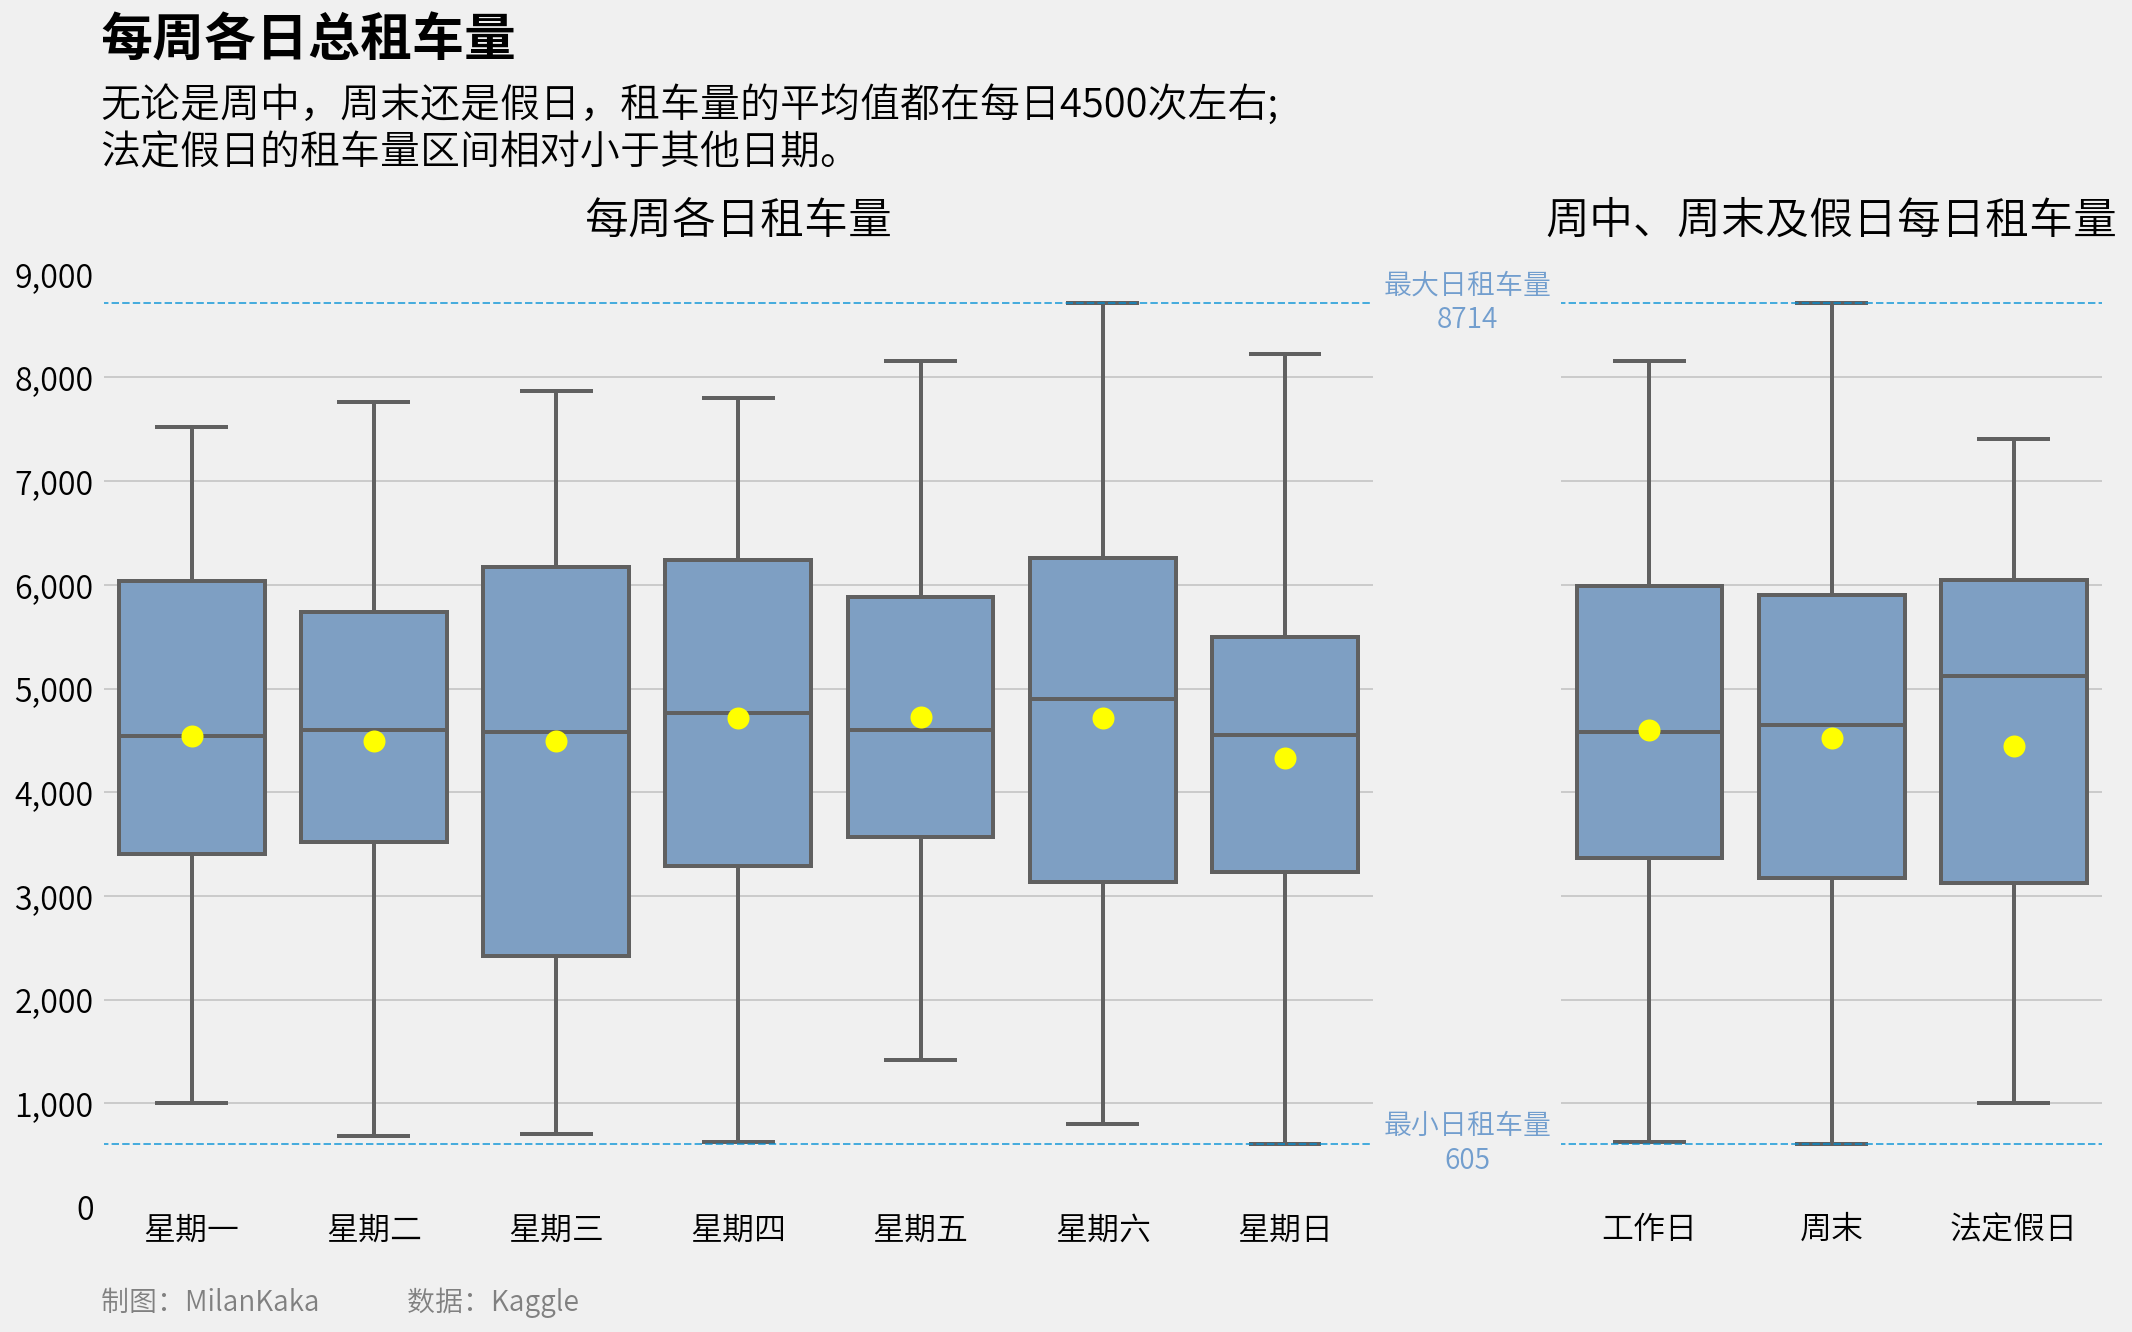

In [106]:
# 设定图表尺寸，长宽比例
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), sharey=True, gridspec_kw = {'width_ratios':[7, 3]})

# 根据星期日数作每日租车量的箱线图
sns.boxplot(x="weekday", y="count", ax=ax1, data=daily_rental, color=c1, linewidth=2, 
            showmeans=True, meanprops=dict(marker='o', markerfacecolor='yellow', markeredgecolor='yellow', markersize=10))

# 美化图表
ax1.set_title('每周各日租车量', fontsize=22, y=1.03)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_ylim(0,9000)
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #添加千位符
ax1.tick_params(labelsize=16)
ax1.margins(1000,500)

# 添加最低和最高值参考线
ax1.axhline(daily_min, xmin=0, xmax=16, linewidth=1, linestyle='--', alpha=0.7)
ax1.text(x=7, y=daily_min+10, s='最小日租车量\n{}'.format(daily_min), ha='center', va='center', fontsize=14, color=c1)
ax1.axhline(daily_max, xmin=0, xmax=16, linewidth=1, linestyle='--', alpha=0.7)
ax1.text(x=7, y=daily_max+10, s='最大日租车量\n{}'.format(daily_max), ha='center', va='center', fontsize=14, color=c1)

# 根据日期类型作箱线图
sns.boxplot(x="day_type", y="count", ax=ax2, data=daily_rental, color=c1, linewidth=2, 
            showmeans=True, meanprops=dict(marker='o', markerfacecolor='yellow', markeredgecolor='yellow', markersize=10))

# 美化图表
ax2.set_title('周中、周末及假日每日租车量', fontsize=22, y=1.03)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.tick_params(labelsize=16)
ax2.axhline(daily_min, xmin=0, xmax=16, linewidth=1, linestyle='--', alpha=0.7)
ax2.axhline(daily_max, xmin=0, xmax=16, linewidth=1, linestyle='--', alpha=0.7)

# 隐去总标题
plt.suptitle('')

# 添加水印
ax1.text(x = -0.5, y = -1000,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

# 根据观察到的数据添加主标题和注释
ax1.text(x = -0.5, y = 11100, s = '每周各日总租车量', fontsize = 26, fontweight = 'bold', color = 'black')
ax1.text(x = -0.5, y = 10400, s = '无论是周中，周末还是假日，租车量的平均值都在每日4500次左右;\n法定假日的租车量区间相对小于其他日期。',
         fontsize = 20, color = 'black', va = 'center')

由上图可见：
* 没有异常值出现，数据相对合理可信。
* 每周各天的平均租车量差距不大，在4500次上下范围波动，星期六的平均租车量相对最高，最高租车量也是在星期六达到。星期日的平均租车量相对最低，而星期五的最低租车量接近1500次，明显高于其他天数（<=1000）。
* 就日期类型而言，工作日，周末和节假日的平均租车量较为接近，节假日的租车量波动范围较小，日租车量中位数明显高于工作日和周末。可以判断用户更倾向在节假日租车，但过低的平均租车量可能是部分节假日出现在租车量清淡的春季导致的。

> 为证明季节因素是否影响不同日期的租车量，笔者另外作图验证了不同季节下，租车量数据都符合每日平均租车量接近的特点，在此略过。

下面继续探索注册用户和非注册用户的在不同天数下的租车情况。

In [107]:
# 计算非注册用户和注册用户的每日租车数据
daily_casual_rental = bike_rental.groupby(['year', 'month', 'day','weekday','day_type'])['casual'].sum().reset_index()
daily_registered_rental = bike_rental.groupby(['year', 'month', 'day','weekday','day_type'])['registered'].sum().reset_index()

In [108]:
# 合并数据
daily_user_rental = daily_casual_rental
daily_user_rental['registered'] = daily_registered_rental['registered']
daily_user_rental.head()

,year,month,day,weekday,day_type,casual,registered
0,2011,1,1,星期六,周末,331,654
1,2011,1,2,星期日,周末,131,670
2,2011,1,3,星期一,工作日,120,1229
3,2011,1,4,星期二,工作日,108,1454
4,2011,1,5,星期三,工作日,82,1518


In [109]:
# 使用pd.melt将casual, registered两列变成user_type一列
daily_user_rental = daily_user_rental.melt(id_vars=['year', 'month', 'day', 'weekday', 'day_type'], 
                                           value_vars=['casual', 'registered'], var_name='user_type', 
                                           value_name='rental')

daily_user_rental.head()

,year,month,day,weekday,day_type,user_type,rental
0,2011,1,1,星期六,周末,casual,331
1,2011,1,2,星期日,周末,casual,131
2,2011,1,3,星期一,工作日,casual,120
3,2011,1,4,星期二,工作日,casual,108
4,2011,1,5,星期三,工作日,casual,82


In [110]:
# 将user_type中值转换
daily_user_rental['user_type'] = daily_user_rental['user_type'].map({'casual': '非注册用户', 'registered': '注册用户'})

Text(-0.5,-1000,'制图：MilanKaka              数据：Kaggle')

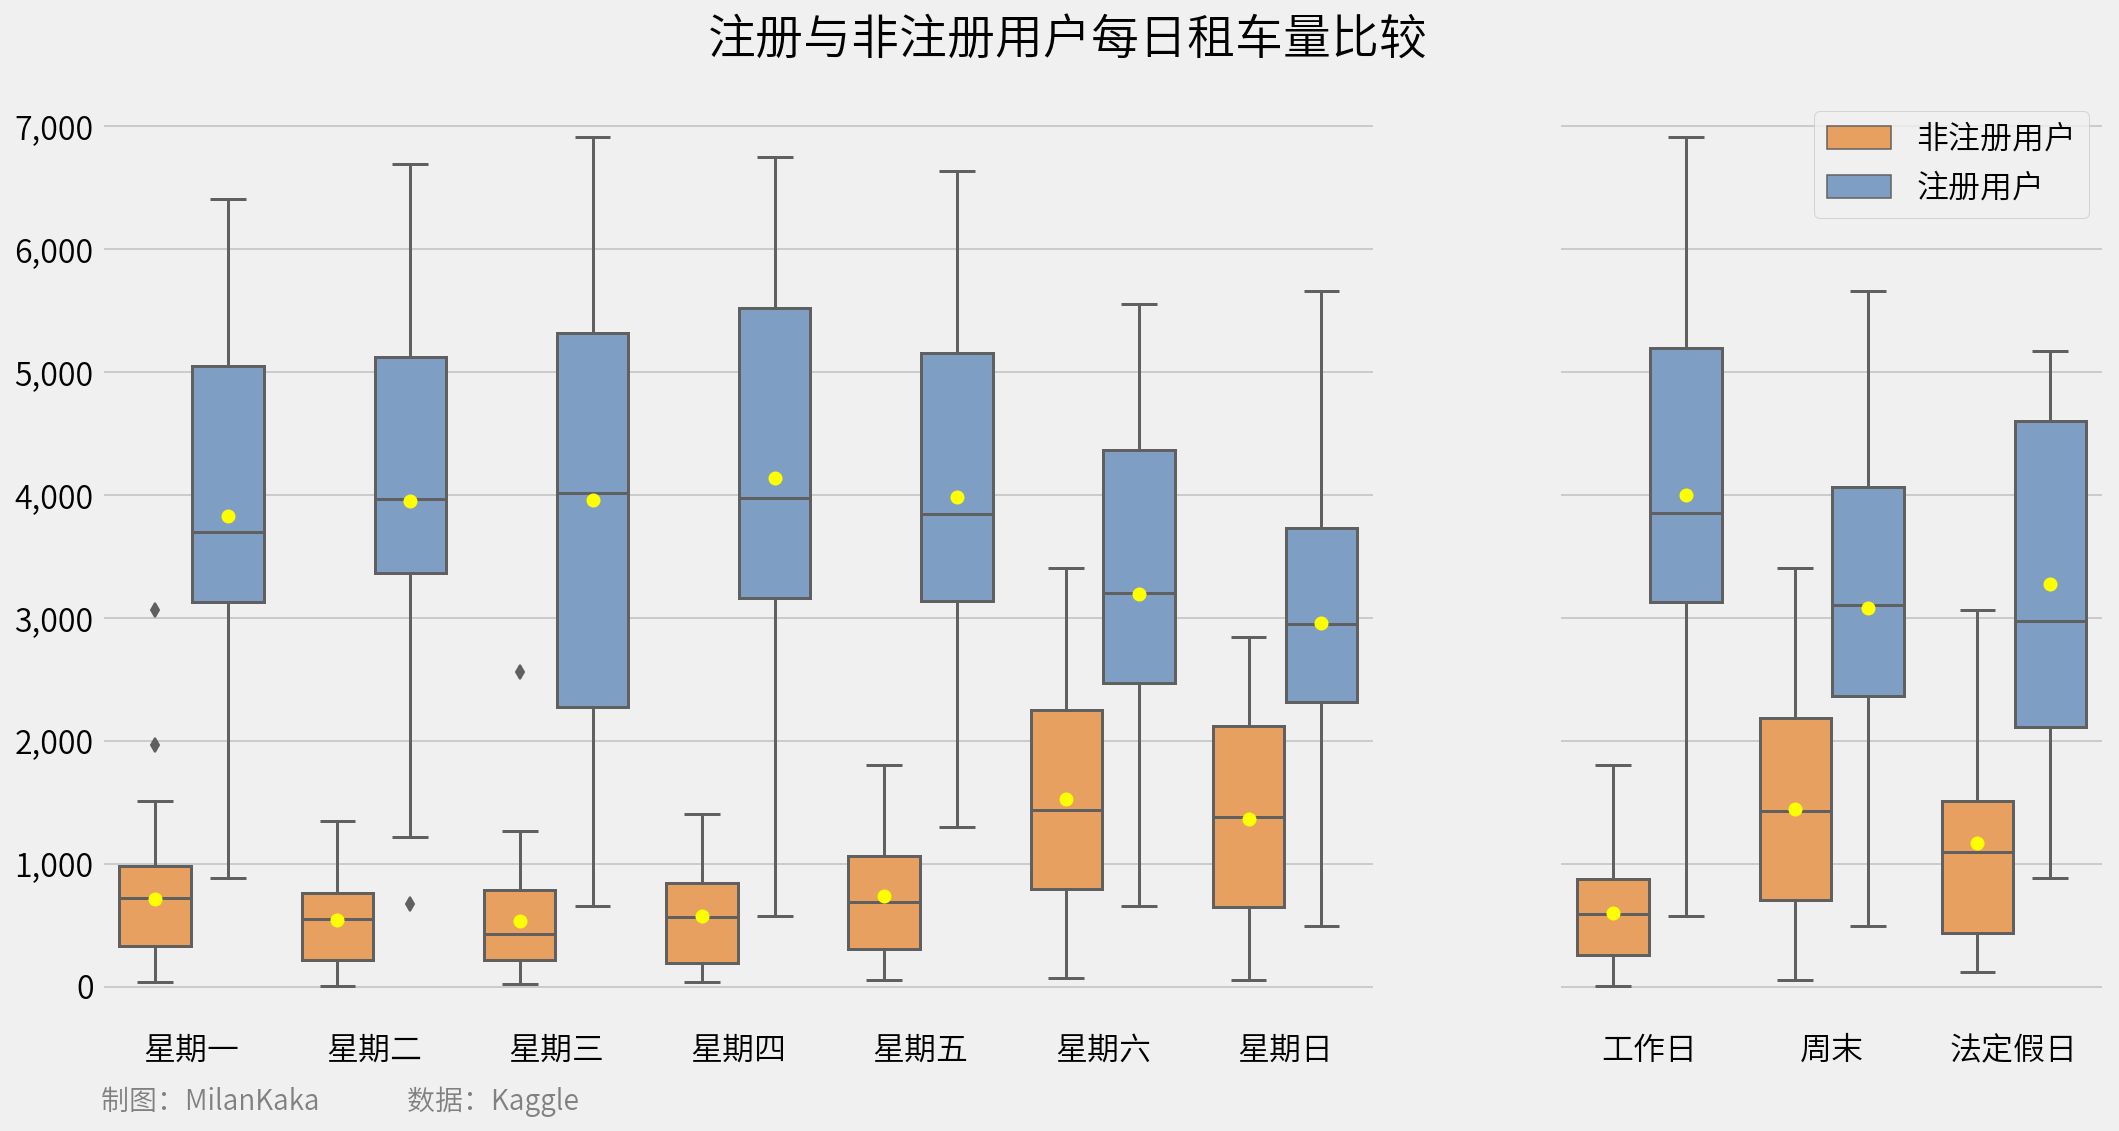

In [111]:
# 设定图表
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16,8), sharey=True, gridspec_kw = {'width_ratios':[7, 3]})
fig.suptitle('注册与非注册用户每日租车量比较', y = 0.95, fontsize=24)

# Plot daily bike rental by user groups in different weekdays
sns.boxplot(x="weekday", y="rental", hue="user_type", ax=ax5,
            data=daily_user_rental, showmeans=True, palette=[c2, c1], linewidth=1.5,
            meanprops=dict(marker='o', markerfacecolor='yellow', markeredgecolor='yellow'))

# Improve plot aesthetics
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax5.tick_params(labelsize=16)
ax5.legend_.remove()


# Plot daily bike rental by user groups in different day types
sns.boxplot(x="day_type", y="rental", hue="user_type", ax=ax6,
            data=daily_user_rental, showmeans=True, palette=[c2, c1], linewidth=1.5,
            meanprops=dict(marker='o', markerfacecolor='yellow', markeredgecolor='yellow'))

# Improve plot aesthetics
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.tick_params(labelsize=16)
ax6.legend(fontsize=16)

# 添加注脚
ax5.text(x = -0.5, y = -1000,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

由上图可见：
* 出现4个异常值，数量很少，其中三个超过上限的异常值很可能是因为当天时节假日造成的。
* 注册用户更倾向在工作日租车，在周末的租车量（约3000/日）明显低于工作日（约4000/日），在节假日的租车量总体介于工作日和周末租车量之间。
* 非注册用户在工作日租车量少（平均值低于1000/日），所占比例很低，在周末租车量（约1500/日）明显提高，但仍低于注册用户租车量。

## 4.3 每天哪个时段的租车量较高？

Text(-1,-100,'制图：MilanKaka              数据：Kaggle')

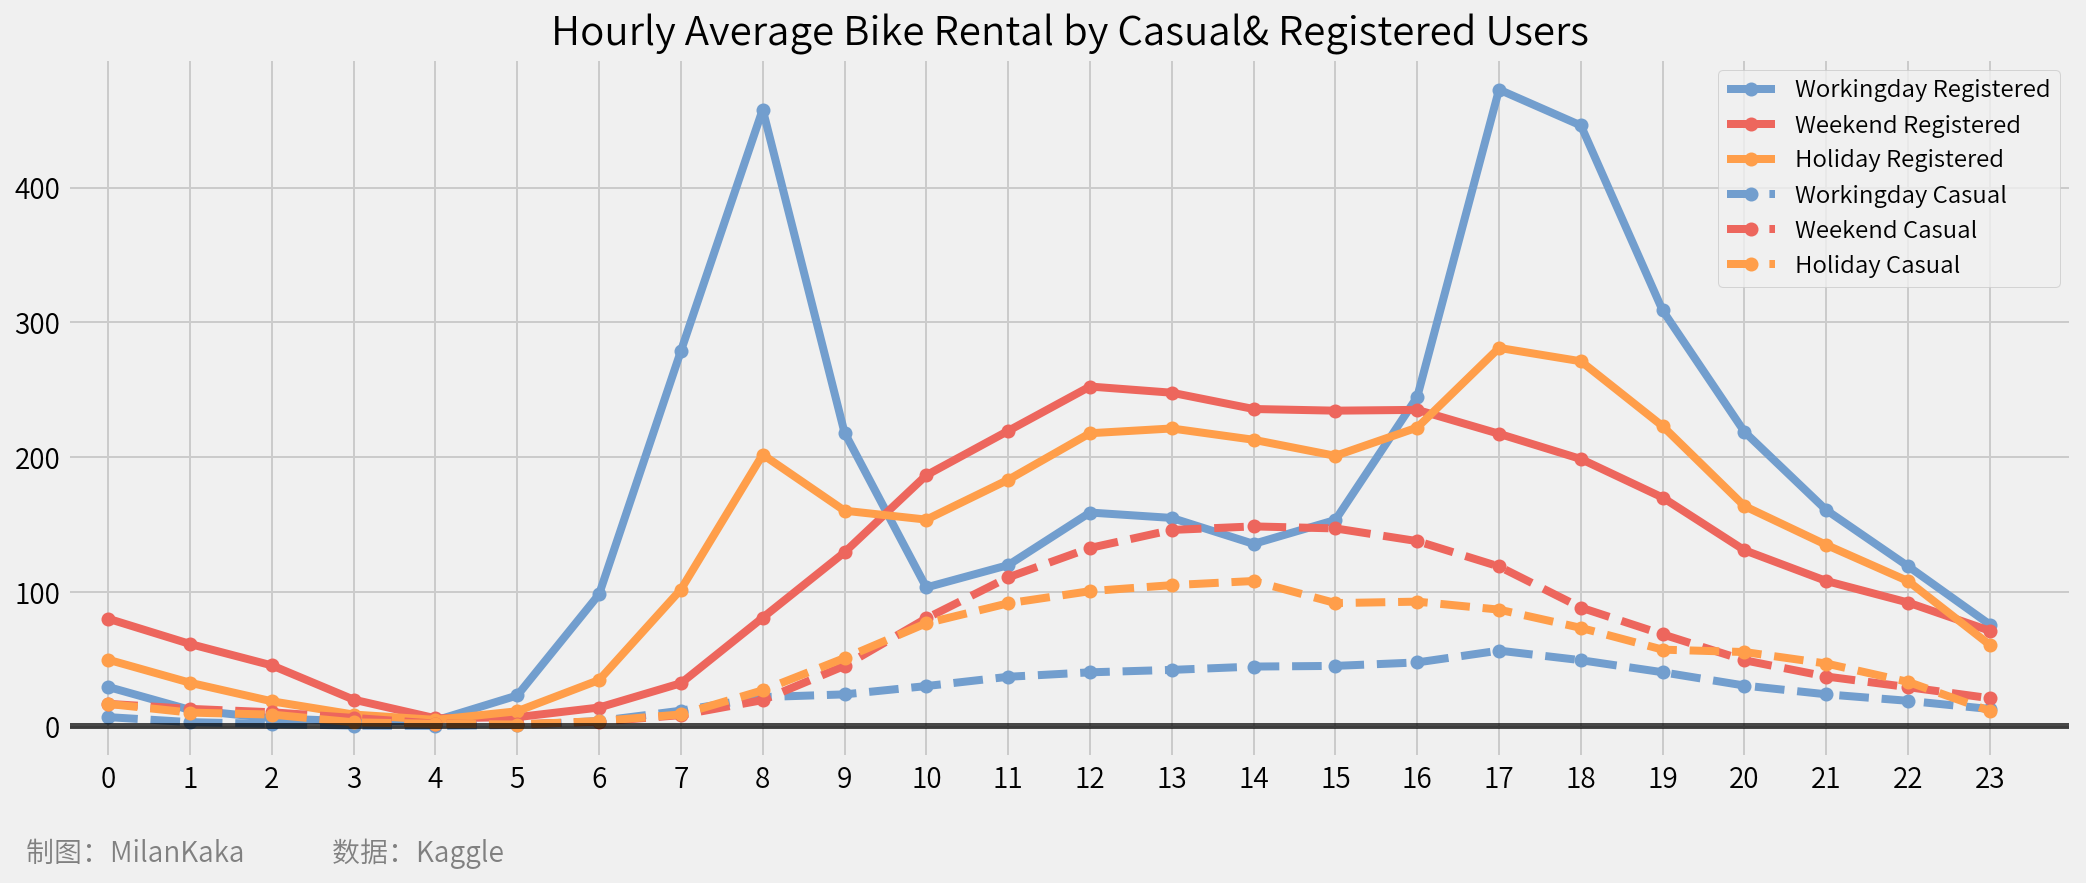

In [112]:
fig, ax9 = plt.subplots(figsize=(16,6))

# Plot hourly average bike rental by different seasons
ax9 = bike_rental.groupby(['hour', 'day_type'])['registered'].mean().unstack().plot(ax=ax9, color=[c1,c4,c2], label='registered', marker='o')

# Plot hourly average bike rental by different day types
ax10 = bike_rental.groupby(['hour', 'day_type'])['casual'].mean().unstack().plot(ax=ax9, linestyle='--', color=[c1,c4,c2], label='casual', marker='o')

# Improve plot aesthetics
ax9.set_title('Hourly Average Bike Rental by Casual& Registered Users')
ax9.set_xlim(-0.5,24)
ax9.set_xticks(np.arange(24))
ax9.set_xlabel('')
ax9.legend(['Workingday Registered', 'Weekend Registered', 'Holiday Registered', 
            'Workingday Casual', 'Weekend Casual', 'Holiday Casual'], fontsize=12)
ax9.axhline(y=0.5, linewidth=3, color='black', alpha=0.7)

# Add signature
ax9.text(x = -1, y = -100,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

由上图可知：
* 用户主要在早上7点到晚上20点间租用共享单车，其中在非工作日，下午12点到下午17点是租车最多的时段。
* 注册用户在工作日的租车集中在7-9点和17-19点，即上下班时间段呈现明显的峰值，在节假日和周末没有明显峰值，因此可以判断注册用户以上班族以及学生为主。
* 非注册用户在工作日租车量很低，没有上下班时段的峰值，在周末和节假日的租车时间习惯上和注册用户区别不大，即集中在下午租车。

Text(-1,-150,'制图：MilanKaka              数据：Kaggle')

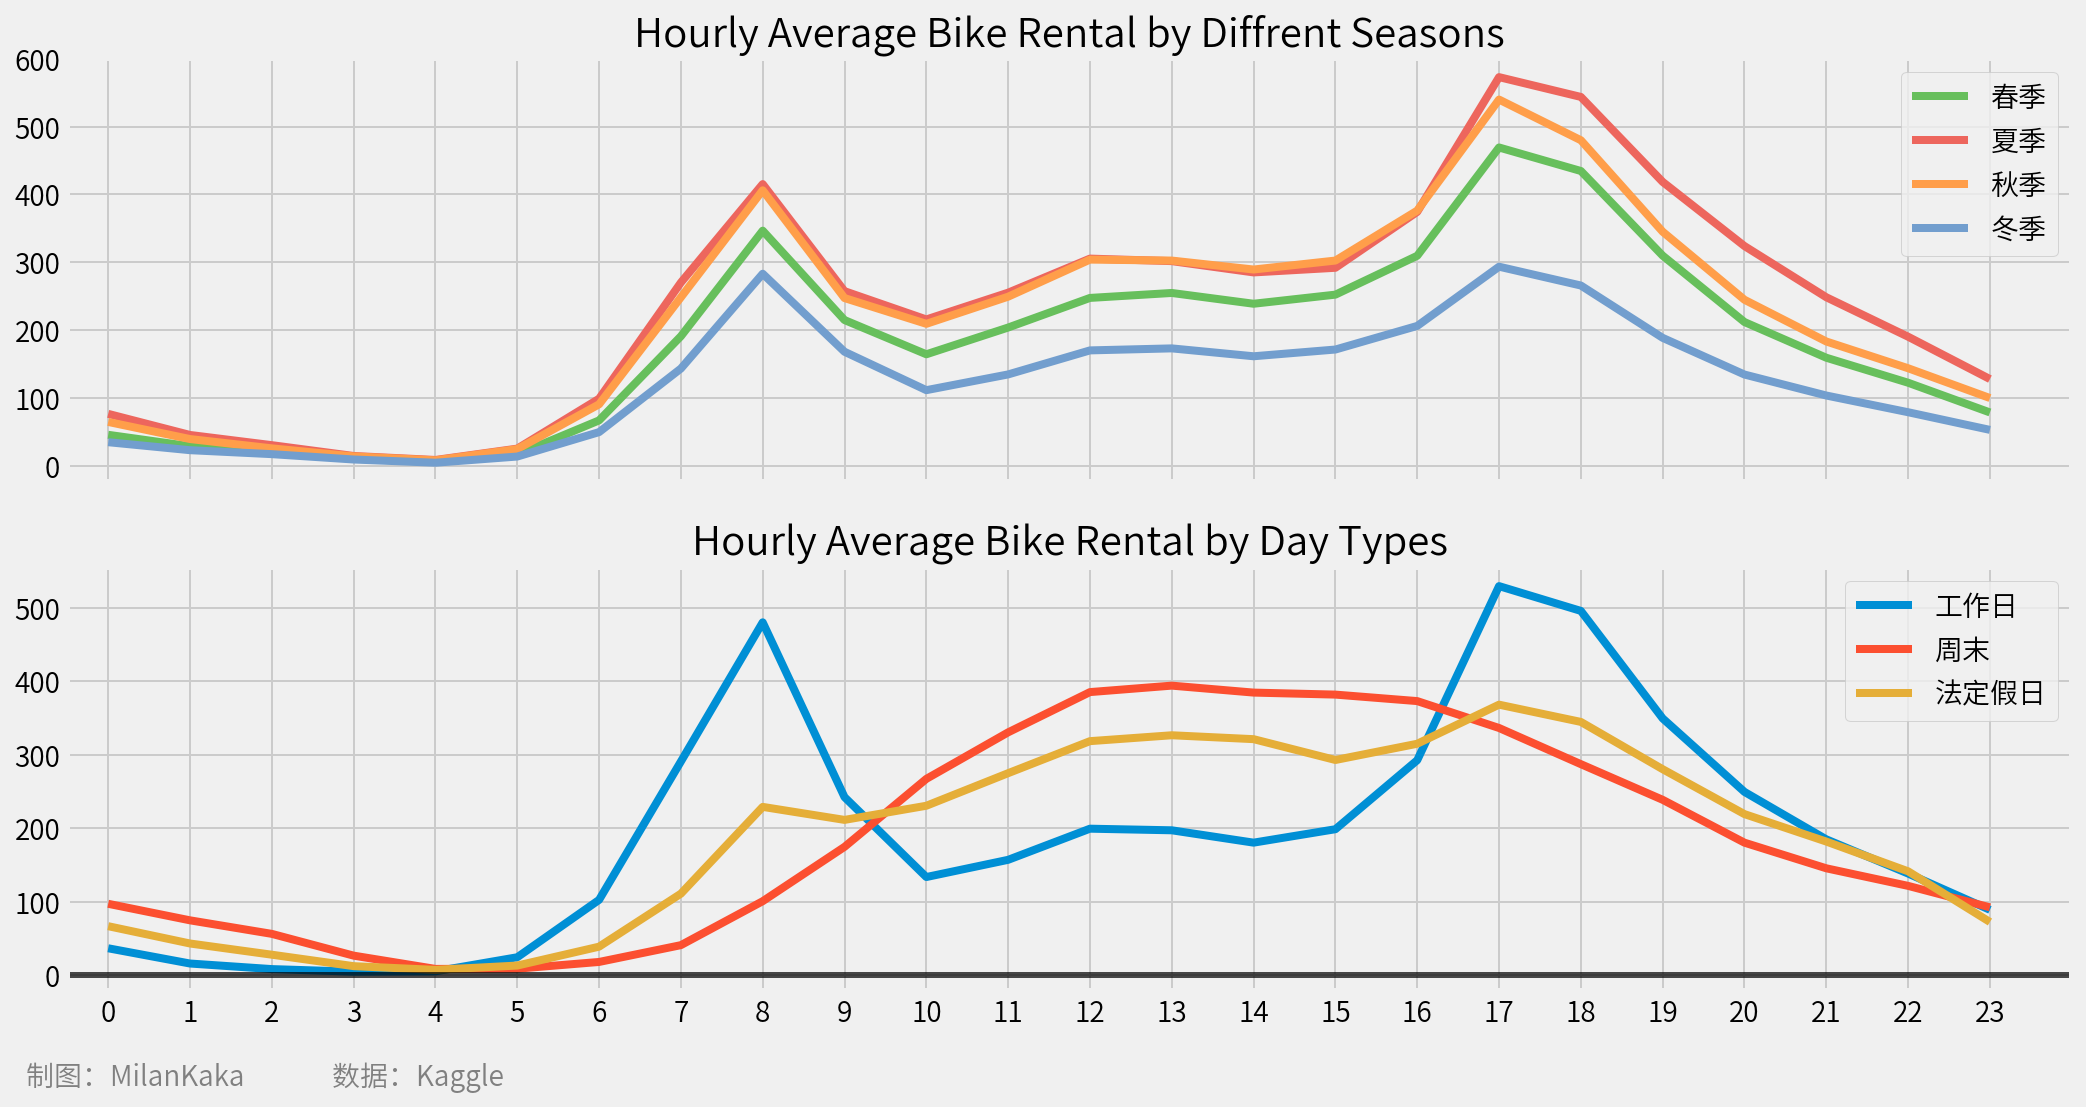

In [113]:
# Set subplots with sharing x-axis
fig, (ax3, ax4) = plt.subplots(2,1, figsize=(16,8), sharex=True)

# Plot hourly average bike rental by different seasons
ax3 = bike_rental.groupby(['hour', 'season'])['count'].mean().unstack().plot(ax=ax3, color=[c3,c4,c2,c1])

# Improve plot aesthetics
ax3.set_title('Hourly Average Bike Rental by Diffrent Seasons')
ax3.set_xticks(np.arange(24))
ax3.legend(title='')


# Plot hourly average bike rental by different day types
ax4 = bike_rental.groupby(['hour', 'day_type'])['count'].mean().unstack().plot(ax=ax4)

# Improve plot aesthetics
ax4.set_title('Hourly Average Bike Rental by Day Types')
ax4.set_xticks(np.arange(24))
ax4.legend(title='')
ax4.set_xlabel(' ')
ax4.set_xlim(-0.5,24)
ax4.axhline(y=0.5, linewidth=3, color='black', alpha=0.7)

# Add signature
ax4.text(x = -1, y = -150,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

## 4.4 天气情况对租车量的影响如何？

天气数据包含天气状况`weather`, 实际温度`temp`, 体感温度`atemp`, 风速`windspeed`, 相对湿度`humidity`，下面逐一作图分析。

> 前文分析过实际温度`temp`和体感温度`atemp`的差值近似保持在2-3度，可以看做是相似变量，因此只选择体感温度`atemp`变量作分析。

### 4.4.1 不同天气状况下的租车量分析

In [121]:
# 统计不同天气状况下的租车量数据
weather_rental = bike_rental.groupby(['weather'])['count'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False).reset_index()
weather_rental

,weather,count,sum,mean
0,晴朗/局部多云,7192,1476063,205.236791
1,多云/薄雾,2834,507160,178.955540
2,小雨/小雪,859,102089,118.846333
3,大雨/大雪及其他,1,164,164.000000


Text(0.5,0.98,'不同天气下的每小时租车量')

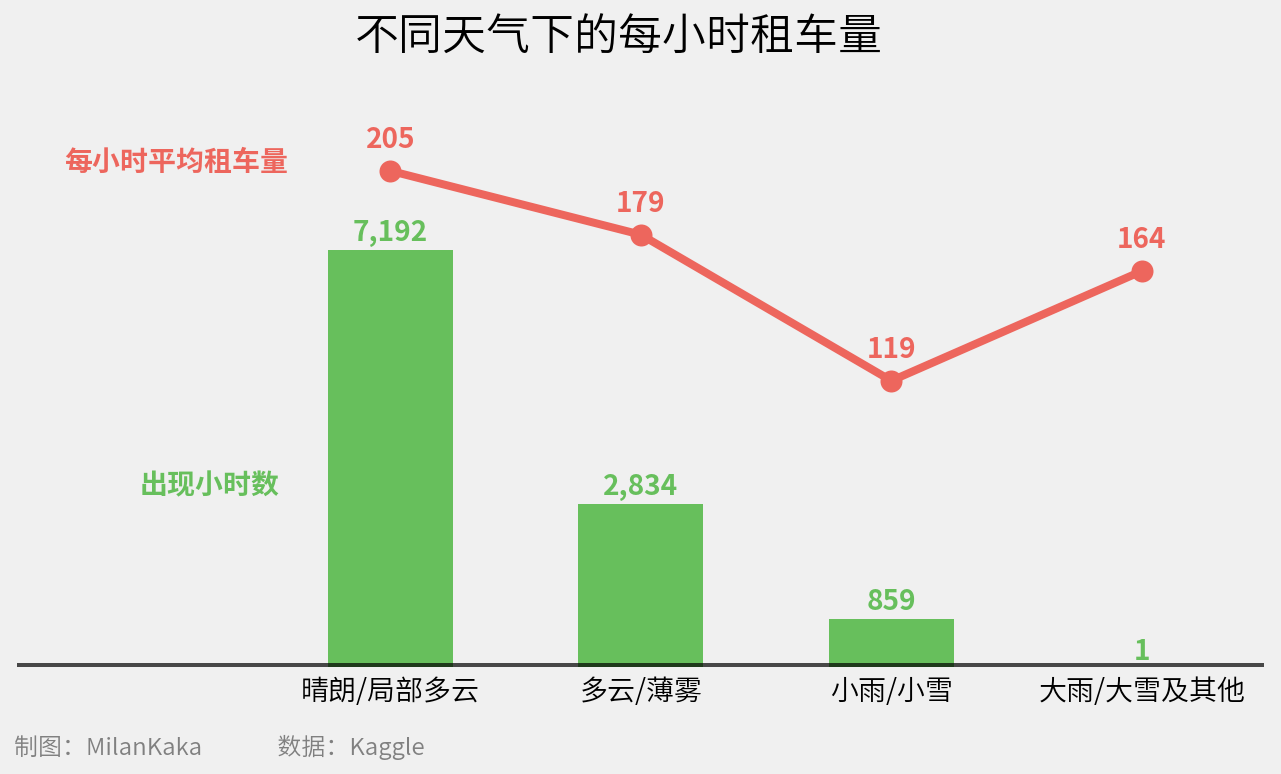

In [125]:
# Plot bike rental data in different weather
fig, ax11 = plt.subplots(figsize=(10,5))

# Plot total bike rental
ax11 = weather_rental['count'].plot(kind='bar', color=c3)

# Improve plot aesthetics
ax11.set_xticklabels(weather_rental['weather'], rotation=0)
ax11.set_xlim(-1.5, 3.5)
ax11.set_ylim(0, 10000)
ax11.tick_params(labelleft=False)
ax11.grid(False)
ax11.annotate('出现小时数', xy=(-1, 3000), fontsize=14, color=c3, weight='bold')

# Add data tag
x1 = np.arange(4)
y1 = weather_rental['count'].values
for x, y in zip(x1, y1):
    ax11.annotate('{:,}'.format(y), xy=(x,y+300), color=c3, fontsize=14, weight='bold', ha='center', va='center')


# Set duel y-axis
ax12 = ax11.twinx()
    
# Plot hourly average bike rental
ax12 = weather_rental['mean'].plot(kind='line', color=c4, marker='o', markersize=10)

# Improve plot aesthetics
ax12.set_ylim(0, 240)
ax12.tick_params(labelright=False)
ax12.grid(False)
ax12.axhline(y=1.5, linewidth=3, color='black', alpha=0.7)
ax12.annotate('每小时平均租车量', xy=(-1.3, 205), fontsize=14, color=c4, weight='bold')

# Add data tag
x2 = np.arange(4)
y2 = weather_rental['mean'].values
for x, y in zip(x2, y2):
    ax12.annotate(int(round(y)), xy=(x,y+7), color=c4, fontsize=14, weight='bold', ha='center', va='bottom')

# Add signature and suptitle    
ax12.text(x = -1.5, y = -35,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 12, color = 'grey')


plt.suptitle('不同天气下的每小时租车量', fontsize=22)

由天气状况-租车数据图可见：
* 天气状况好时的租车量高于天气状况差的时候。晴天/少云和多云/薄雾天气下的租车量明显高于雨雪天气时。暴雨/大学天气只出现了一次，因此平均租车数据不具参考性。
* 晴天/少云天气下的总租车量大大超过其他天气状况，可以判断华盛顿特区气候宜人，天气多以晴天/少云为主。

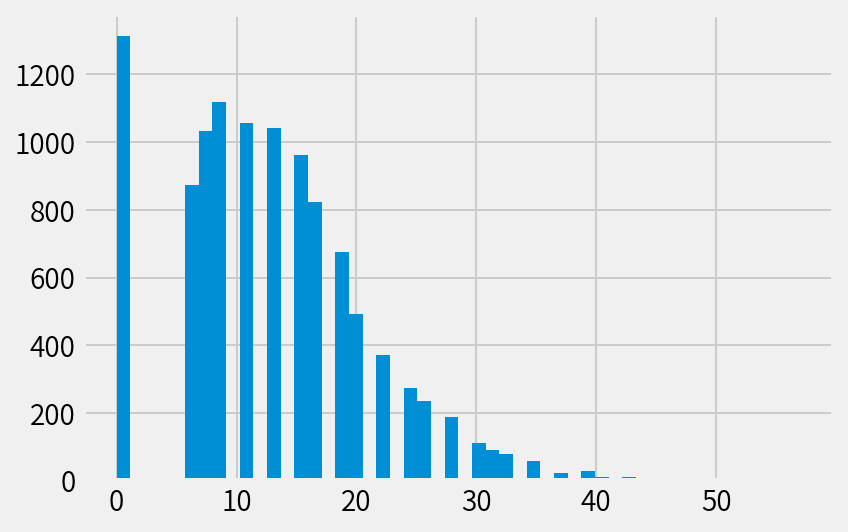

In [86]:
bike_rental['windspeed'].hist(bins=50)

In [87]:
bike_rental['windspeed'].nunique()

28

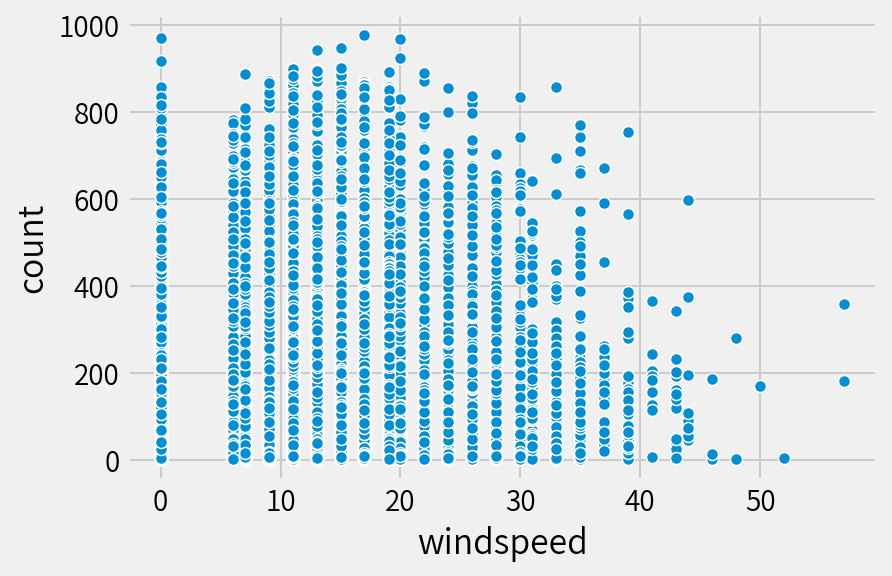

In [88]:
sns.scatterplot(data=bike_rental, x='windspeed', y='count')

In [205]:
def ecdf(data):
    # number of data points
    n = len(data)
    # x-data for ECDF
    x = np.sort(data)
    # y-data for ECDF
    y = np.arange(1, n+1) / n
    
    return x, y

In [175]:
a, b = ecdf(bike_rental['windspeed'])

In [252]:
d

array([ 211526,  340464,  516091,  712814,  926605, 1137349, 1339960,
       1516994, 1664397, 1775213, 1844053, 1904336, 1958091, 1999112,
       2023218, 2041815, 2056541, 2069890, 2074225, 2079001, 2081084,
       2082739, 2084278, 2084480, 2084761, 2084932, 2084937, 2085476])

In [190]:
c = np.unique(a)

In [189]:
d = bike_rental.groupby('windspeed')['count'].sum().values.cumsum()

### 4.4.2 不同风速下的租车量分析

Text(-9.49948,-0.17,'   ©MilankakaZhang                                                              Data Source: Kaggle')

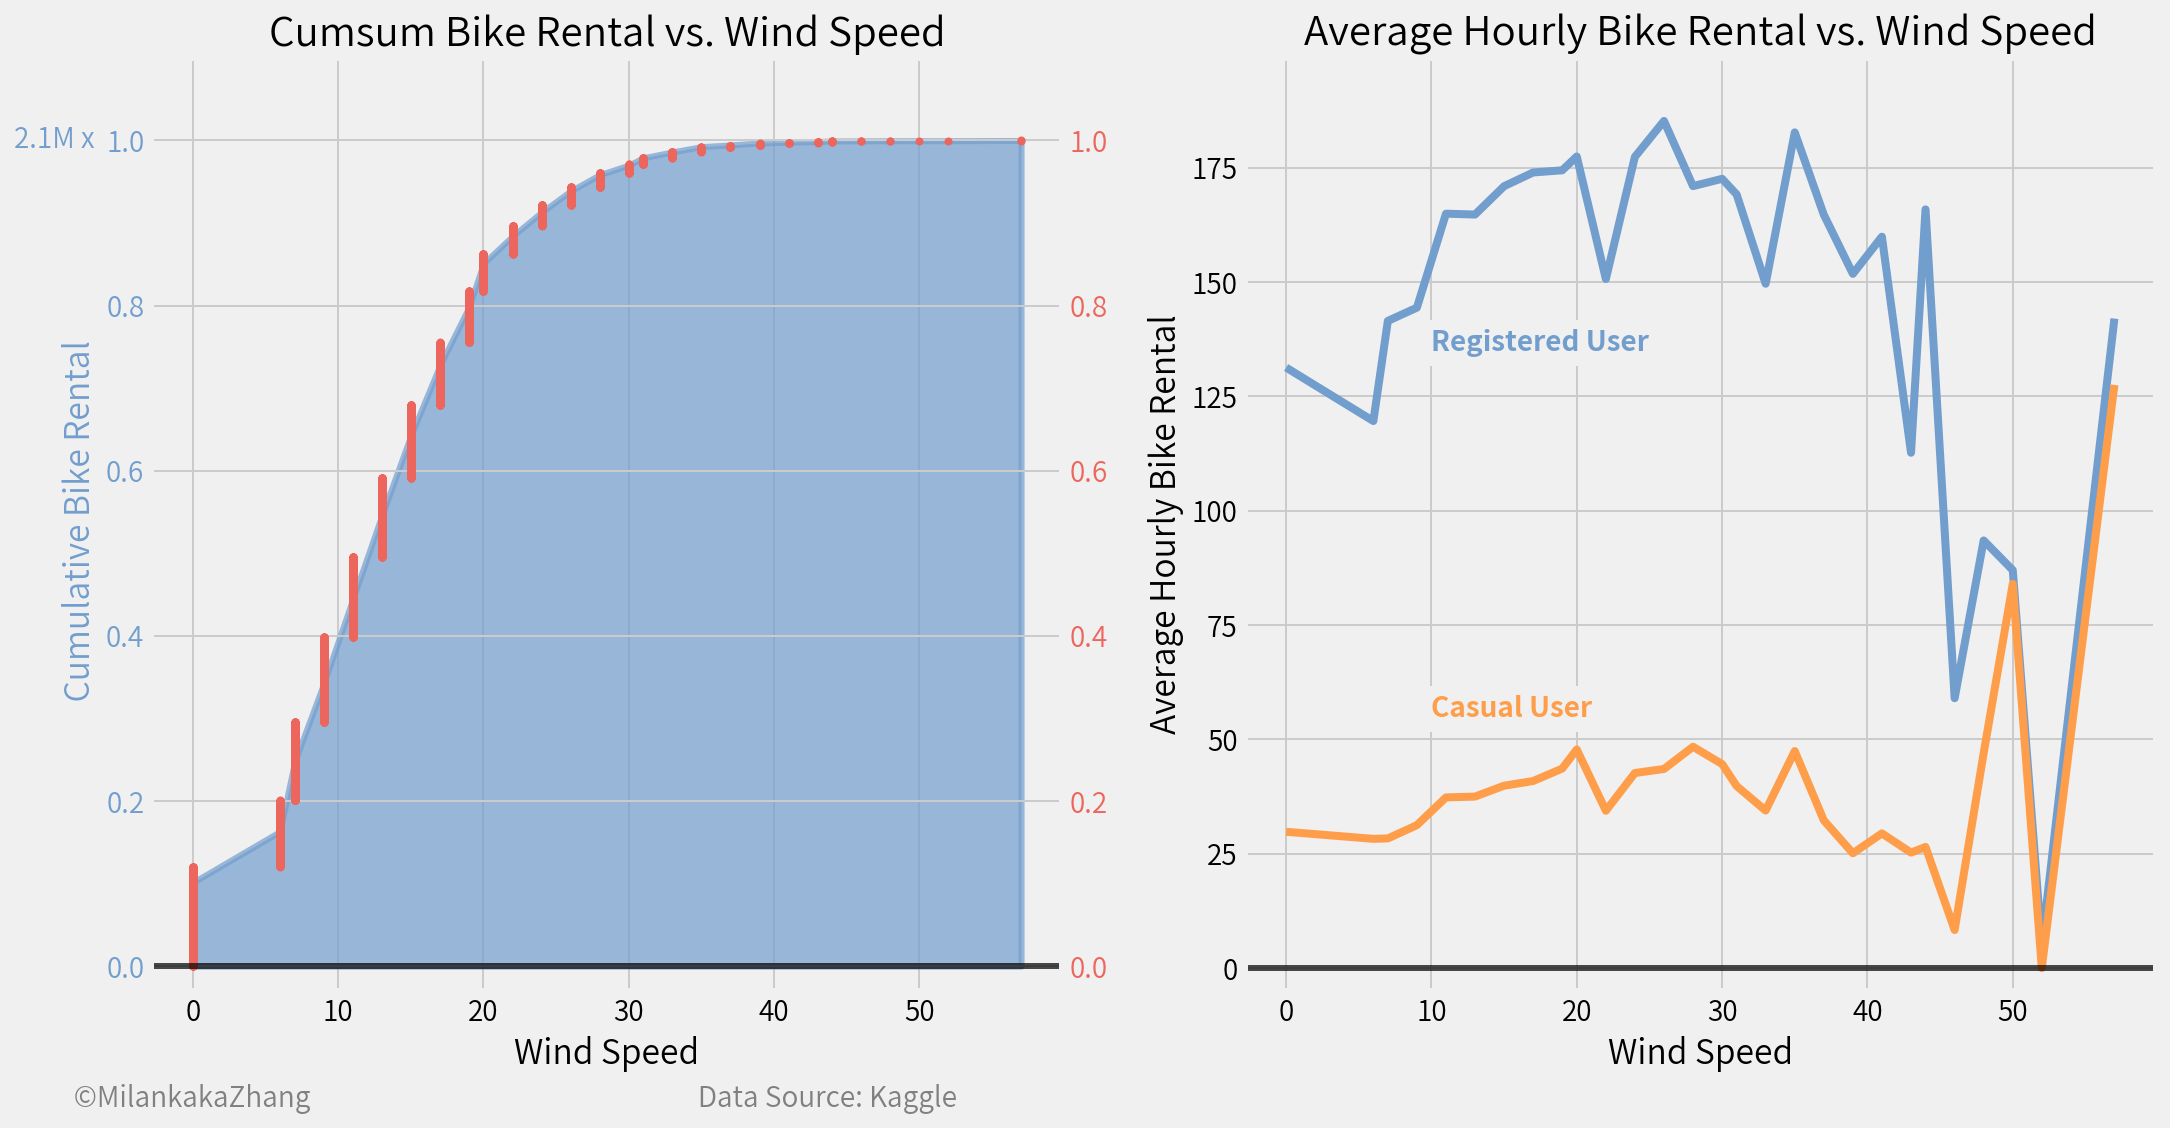

In [206]:
a, b =ecdf(bike_rental['windspeed'])
c = np.unique(a)
d = bike_rental.groupby('windspeed')['count'].sum().values.cumsum()

fig,(ax1, ax3) = plt.subplots(1,2, figsize=(16,8))

# Plot the cumsum bike rental in different windspeed
ax1.fill_between(c, d/d[-1], color=c1, linewidth=3, alpha=0.7)

ax1.set_title('Cumsum Bike Rental vs. Wind Speed')
ax1.set_ylim(-0.03, 1.1)
ax1.set_ylabel(' Cumulative Bike Rental')
ax1.set_xlabel('Wind Speed')
for ytick in ax1.get_yticklabels():
    ytick.set_color(c1)

    
# Plot the bike rental ECDF in different speed
ax2 = ax1.twinx()
ax2.plot(a, b, marker='.', linestyle='none', color=c4)
ax2.set_ylim(-0.03,1.1)

for ytick in ax2.get_yticklabels():
    ytick.set_color(c4)

ax2.axhline(y=0, linewidth=3, color='black', alpha=0.7)
ax2.text(x=-(max(c)/6), y=1, s='2.1M x', color=c1, va='center', ha='center')

ax3 = bike_rental.groupby('windspeed')['registered'].mean().plot(ax=ax3, color=c1)
ax4 = bike_rental.groupby('windspeed')['casual'].mean().plot(ax=ax3, color=c2)
#ax5 = bike_rental.groupby('windspeed')['count'].mean().plot(ax=ax3, color=c3)
ax3.set_title('Average Hourly Bike Rental vs. Wind Speed')
ax3.set_ylim(-5,199)
ax3.set_ylabel('Average Hourly Bike Rental')
ax3.set_xlabel('Wind Speed')
ax3.text(x=10, y=135, s='Registered User', color=c1, weight='bold', backgroundcolor='#f0f0f0')
ax4.text(x=10, y=55, s='Casual User', color=c2, weight='bold', backgroundcolor='#f0f0f0')
ax3.axhline(y=0, linewidth=3, color='black', alpha=0.7)

# Add signature and suptitle    
ax1.text(x = -(max(c)/6), y = -0.17,
    s = '   ©MilankakaZhang                                                              Data Source: Kaggle',
    fontsize = 14, color = 'grey')

由风速-租车量关系图可见：
* 左图x轴是风速，红色竖线的长度代表风速的分布比例，蓝色面积图是随风速增加的租车量累积。
* 超过80%的时间段风速在20以下，另外接近20%的时段风速在20-40区间，40以上的风速的时间段极少。根据[风力等级表](https://baike.baidu.com/item/%E9%A3%8E%E5%8A%9B%E7%AD%89%E7%BA%A7)，推断风速单位是km/h。
* 根据左图左侧y轴，华盛顿特区两年累积租车量约为210万次。
* 忽略风速40km/h以上的情况，风速10-35km/h/区间的平均租车量高于其他风速的租车量。用户更倾向在轻风与和风中使用共享单车。

Text(-8,-0.17,'   ©MilankakaZhang                                                              Data Source: Kaggle')

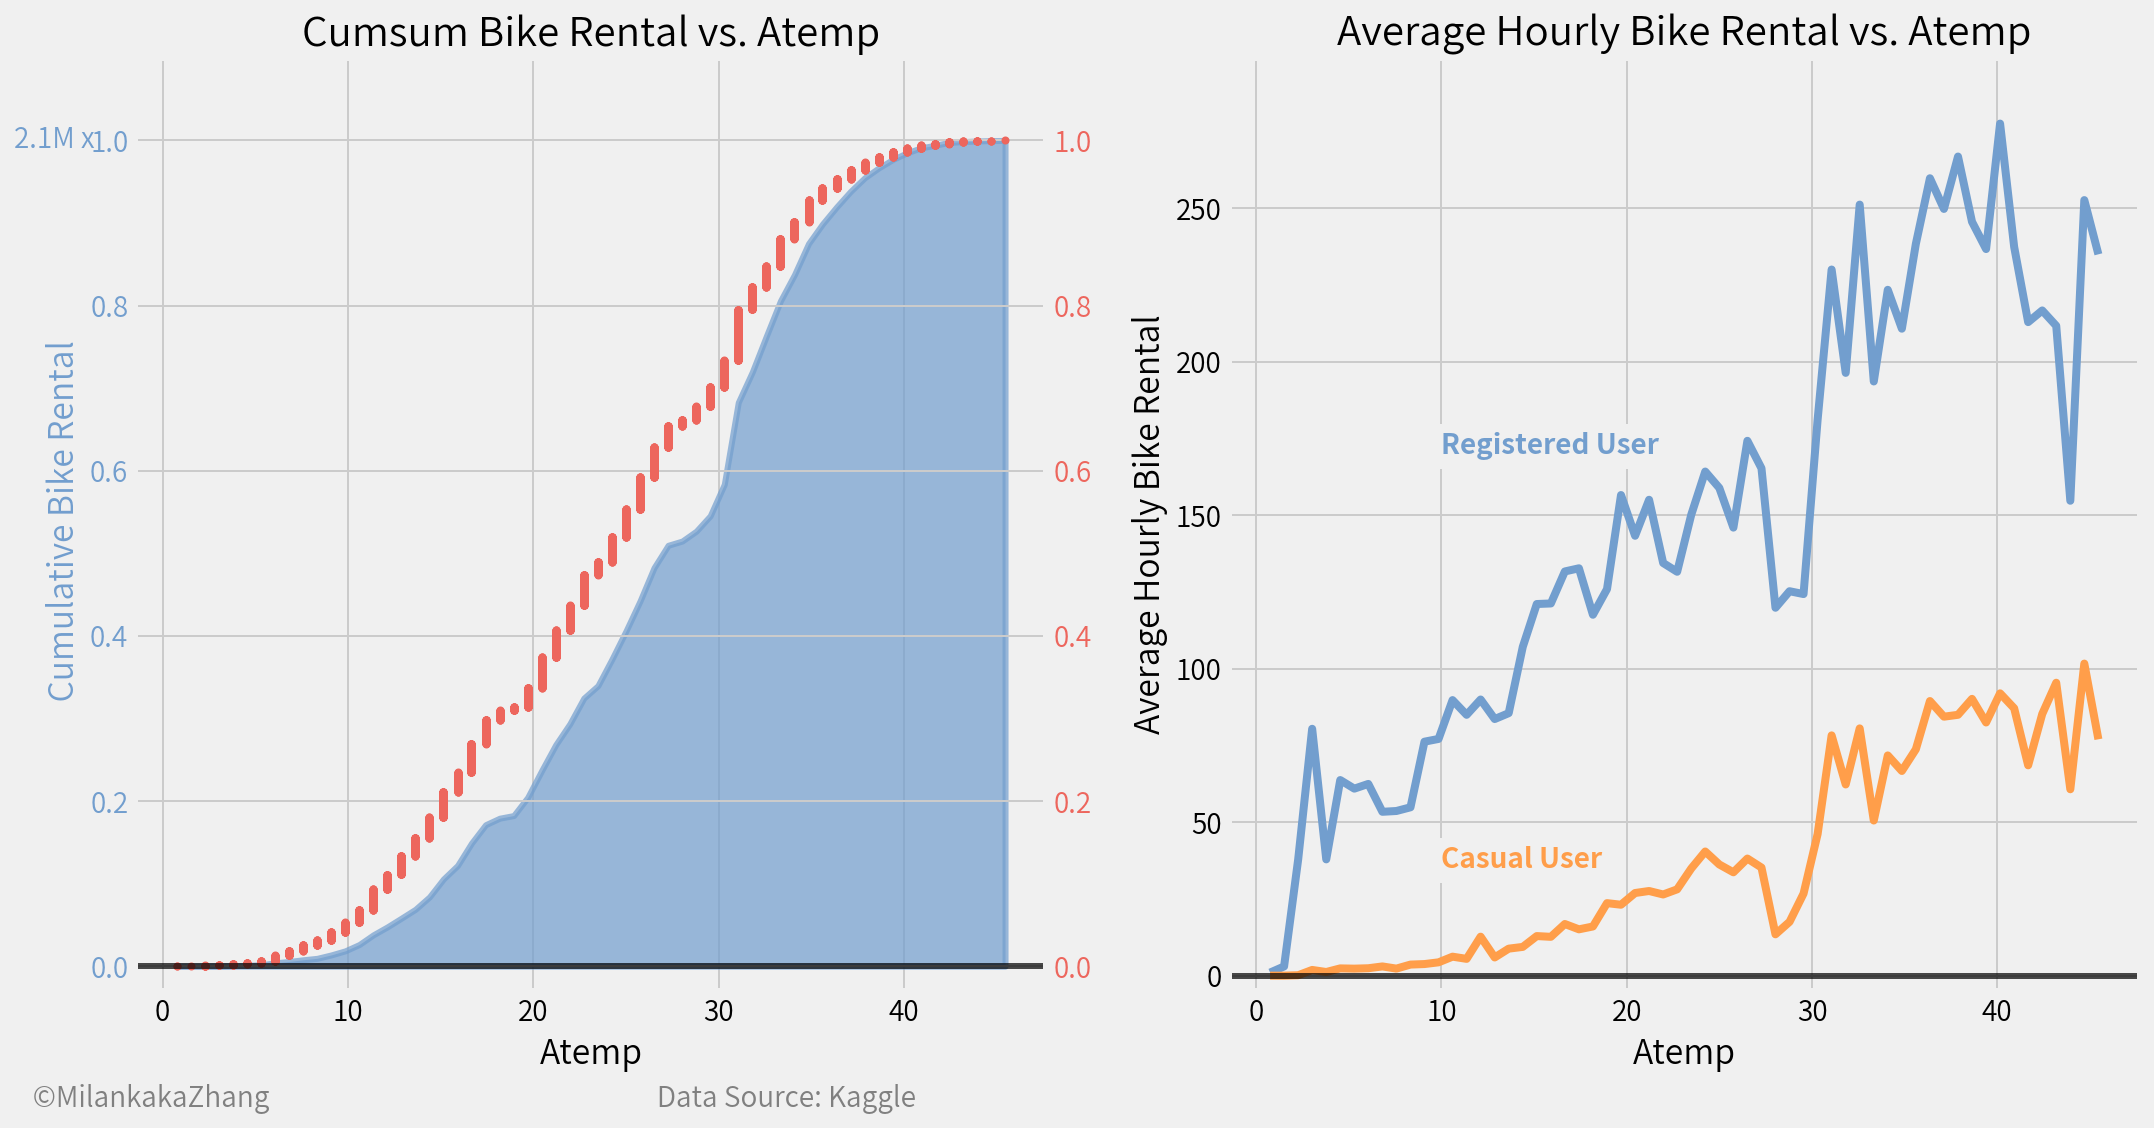

In [207]:
# Calculate rental-temp data
a, b =ecdf(bike_rental['atemp'])
c = np.unique(a)
d = bike_rental.groupby('atemp')['count'].sum().values.cumsum()

# Plot rental-temp chart
fig,(ax1, ax3) = plt.subplots(1,2, figsize=(16,8))

# Plot the cumsum bike rental vs. temp
ax1.fill_between(c, d/d[-1], color=c1, linewidth=3, alpha=0.7)

ax1.set_title('Cumsum Bike Rental vs. Atemp')
ax1.set_ylim(-0.03, 1.1)
ax1.set_ylabel(' Cumulative Bike Rental', color=c1)
ax1.set_xlabel('Atemp')
for ytick in ax1.get_yticklabels():
    ytick.set_color(c1)

    
# Plot temp ECDF
ax2 = ax1.twinx()
ax2.plot(a, b, marker='.', linestyle='none', color=c4)
ax2.set_ylim(-0.03,1.1)

for ytick in ax2.get_yticklabels():
    ytick.set_color(c4)

ax2.axhline(y=0, linewidth=3, color='black', alpha=0.7)
ax2.text(x=-8, y=1, s='2.1M x', color=c1, va='center')

# Plot hourly bike rental curve
ax3 = bike_rental.groupby('atemp')['registered'].mean().plot(ax=ax3, color=c1)
ax4 = bike_rental.groupby('atemp')['casual'].mean().plot(ax=ax3, color=c2)
#ax5 = bike_rental.groupby('windspeed')['count'].mean().plot(ax=ax3, color=c3)

ax3.set_title('Average Hourly Bike Rental vs. Atemp')
ax3.set_ylim(-5,299)
ax3.set_ylabel('Average Hourly Bike Rental')
ax3.set_xlabel('Atemp')
ax3.text(x=10, y=170, s='Registered User', color=c1, weight='bold', backgroundcolor='#f0f0f0')
ax4.text(x=10, y=35, s='Casual User', color=c2, weight='bold', backgroundcolor='#f0f0f0')
ax3.axhline(y=0, linewidth=3, color='black', alpha=0.7)

# Add signature and suptitle    
ax1.text(x = -8, y = -0.17,
    s = '   ©MilankakaZhang                                                              Data Source: Kaggle',
    fontsize = 14, color = 'grey')

由体感温度-租车量关系图可知：
* 体感温度主要分布在5到35摄氏度，分布相对平均。
* 考虑5到35摄氏度的区间，无论是注册用户还是非注册用户，平均租车量基本都随着温度的上升而明显提高。用户更倾向在温暖炎热的天气下租车。

Text(-20,-0.17,'   ©MilankakaZhang                                                              Data Source: Kaggle')

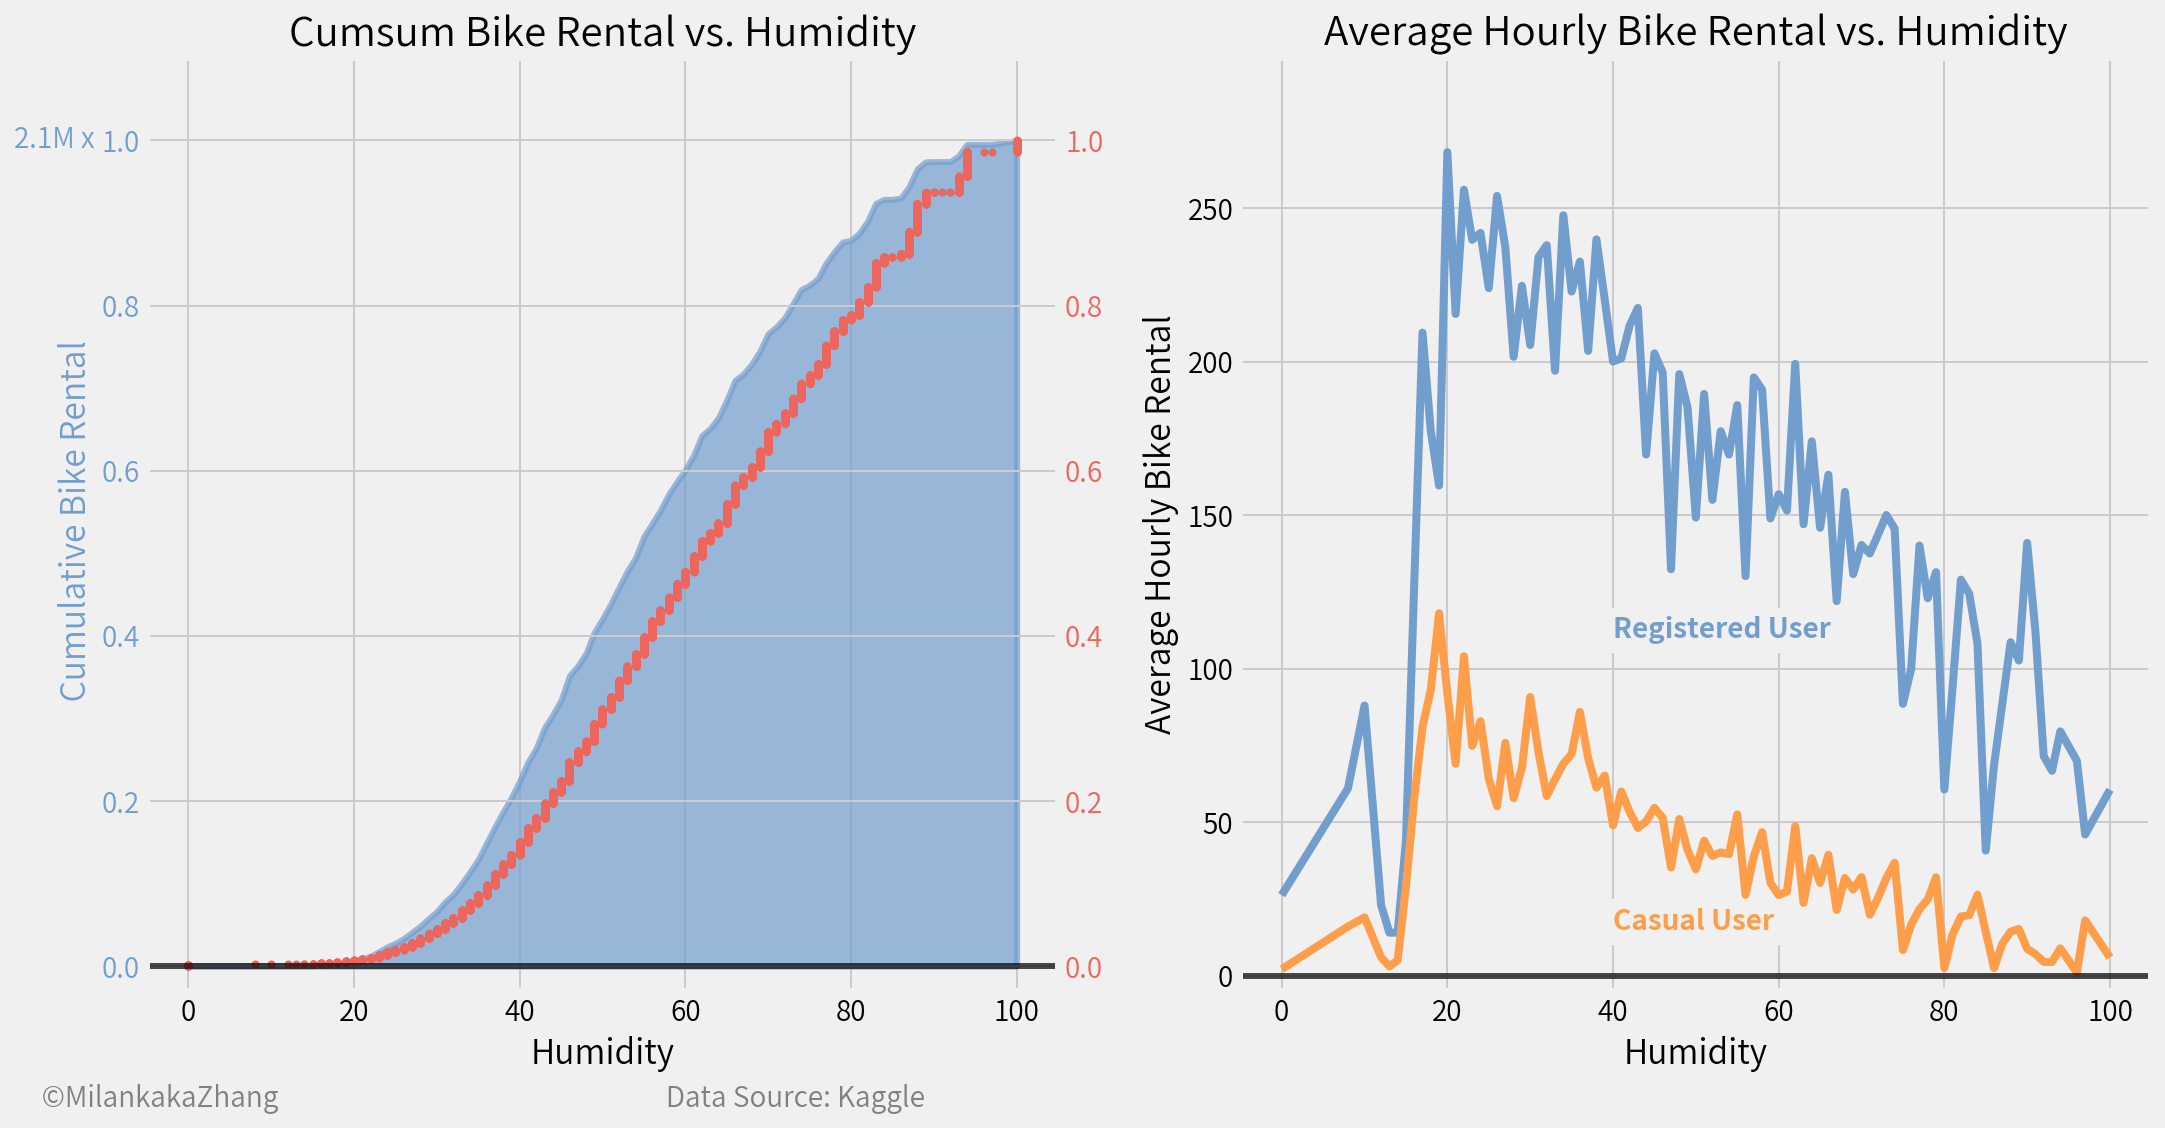

In [208]:
# Calculate rental-humidity data

a, b =ecdf(bike_rental['humidity'])
c = np.unique(a)
d = bike_rental.groupby('humidity')['count'].sum().values.cumsum()

# Plot rental-humidity chart
fig,(ax1, ax3) = plt.subplots(1,2, figsize=(16,8))

# Plot the cumsum bike rental vs. humidity
ax1.fill_between(c, d/d[-1], color=c1, linewidth=3, alpha=0.7)

ax1.set_title('Cumsum Bike Rental vs. Humidity')
ax1.set_ylim(-0.03, 1.1)
ax1.set_ylabel(' Cumulative Bike Rental', color=c1)
ax1.set_xlabel('Humidity')
for ytick in ax1.get_yticklabels():
    ytick.set_color(c1)

    
# Plot humidity ECDF
ax2 = ax1.twinx()
ax2.plot(a, b, marker='.', linestyle='none', color=c4)
ax2.set_ylim(-0.03,1.1)
for ytick in ax2.get_yticklabels():
    ytick.set_color(c4)

ax2.axhline(y=0, linewidth=3, color='black', alpha=0.7)
ax2.text(x=-21, y=1, s='2.1M x', color=c1, va='center')

# Plot average hourly bike rental vs. humidity
ax3 = bike_rental.groupby('humidity')['registered'].mean().plot(ax=ax3, color=c1)
ax4 = bike_rental.groupby('humidity')['casual'].mean().plot(ax=ax3, color=c2)

ax3.set_title('Average Hourly Bike Rental vs. Humidity')
ax3.set_ylim(-5,299)
ax3.set_ylabel('Average Hourly Bike Rental')
ax3.set_xlabel('Humidity')
ax3.text(x=40, y=110, s='Registered User', color=c1, weight='bold', backgroundcolor='#f0f0f0')
ax4.text(x=40, y=15, s='Casual User', color=c2, weight='bold', backgroundcolor='#f0f0f0')
ax3.axhline(y=0, linewidth=3, color='black', alpha=0.7)

# Add signature and suptitle    
ax1.text(x = -20, y = -0.17,
    s = '   ©MilankakaZhang                                                              Data Source: Kaggle',
    fontsize = 14, color = 'grey')

由湿度-租车量关系图可知：
* 湿度主要集中在20至100区间，分布相对平均。
* 考虑湿度20-100的时候，注册用户和非注册用户的平均租车量都随着湿度的升高而显著下降。湿度20的时候租车量最高。

Text(-0.5,-100,'制图：MilanKaka              数据：Kaggle')

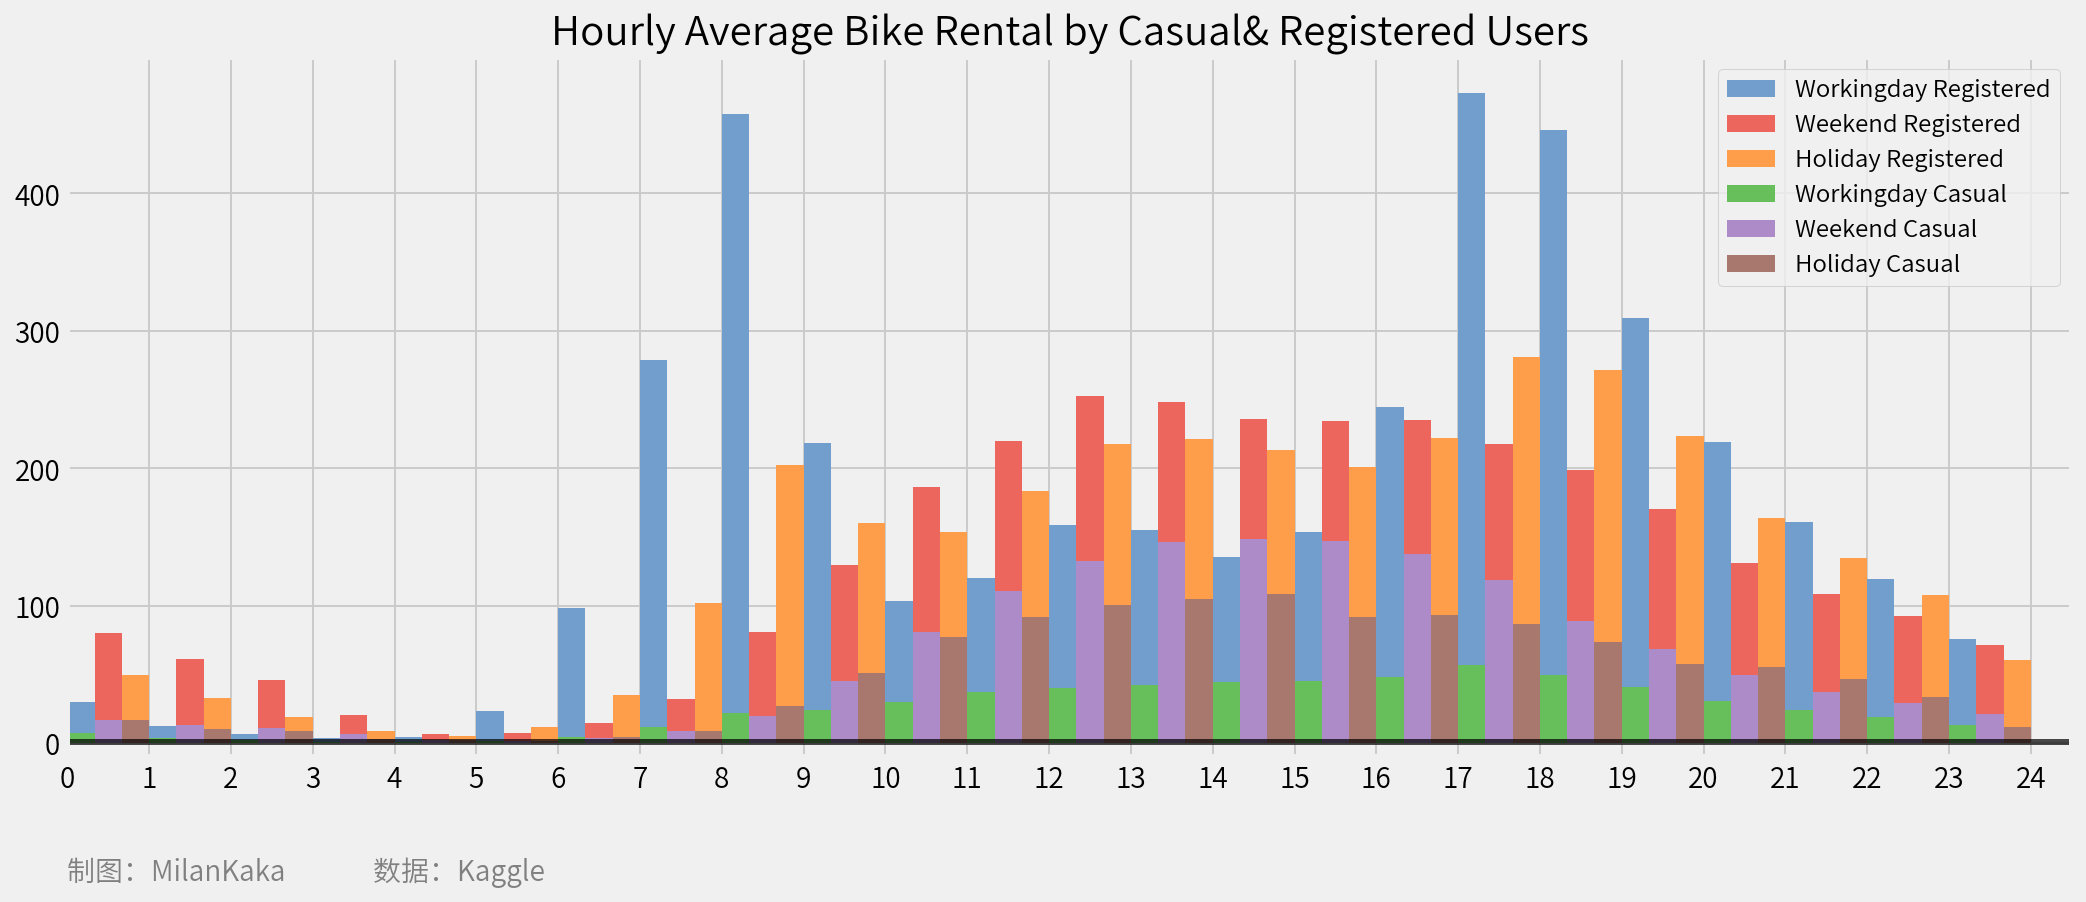

In [338]:
# bar chart for rent in different days

fig, ax9 = plt.subplots(figsize=(16,6))

# Plot hourly average bike rental by different seasons
ax9 = bike_rental.groupby(['hour', 'day_type'])['registered'].mean().unstack().plot.bar(ax=ax9, color=[c1,c4,c2], 
                                                                                    label='registered', width=1)

# Plot hourly average bike rental by different day types
ax10 = bike_rental.groupby(['hour', 'day_type'])['casual'].mean().unstack().plot.bar(ax=ax9, linestyle='--', color=[c3,c5,c6], 
                                                                                     label='casual', width=1)

# Improve plot aesthetics
ax9.set_title('Hourly Average Bike Rental by Casual& Registered Users')
ax9.set_xlim(-0.5,24)
ax9.set_ylim(-10, 499)
ax9.set_xticks(np.arange(25)-0.5)
ax9.set_xticklabels(np.arange(25), rotation=0)
ax9.set_xlabel('')
ax9.legend(['Workingday Registered', 'Weekend Registered', 'Holiday Registered', 
            'Workingday Casual', 'Weekend Casual', 'Holiday Casual'], fontsize=12)
ax9.axhline(y=1, linewidth=3, color='black', alpha=0.7)

# Add signature
ax9.text(x = -0.5, y = -100,
    s = '制图：MilanKaka              数据：Kaggle',
    fontsize = 14, color = 'grey')

In [346]:
sample1 = bike_rental.sample(1000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


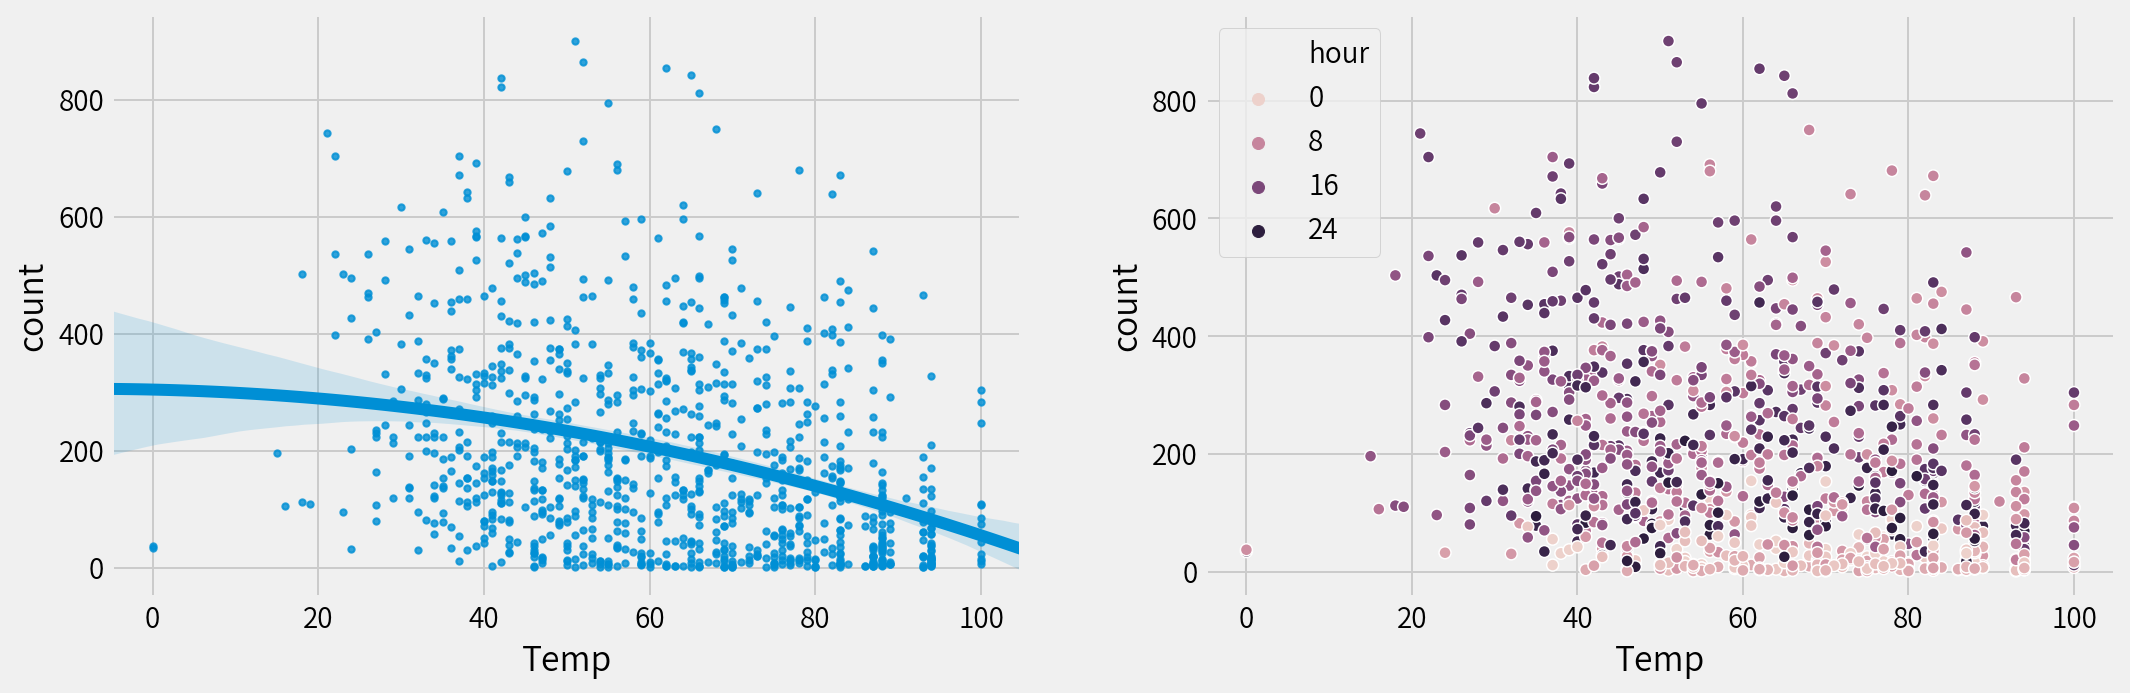

In [349]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1 = sns.regplot(data=sample1, x='humidity', y='count', order=2, scatter_kws={"s": 10}, ax=ax1)
ax1.set_xlabel('Temp')
ax1.set_ylabel=('Hourly Bike Rental')

ax2 = sns.scatterplot(data=sample1, x='humidity', y='count', hue='hour', ax=ax2)

ax2.set_xlabel('Temp')
ax2.set_ylabel=('Hourly Bike Rental')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


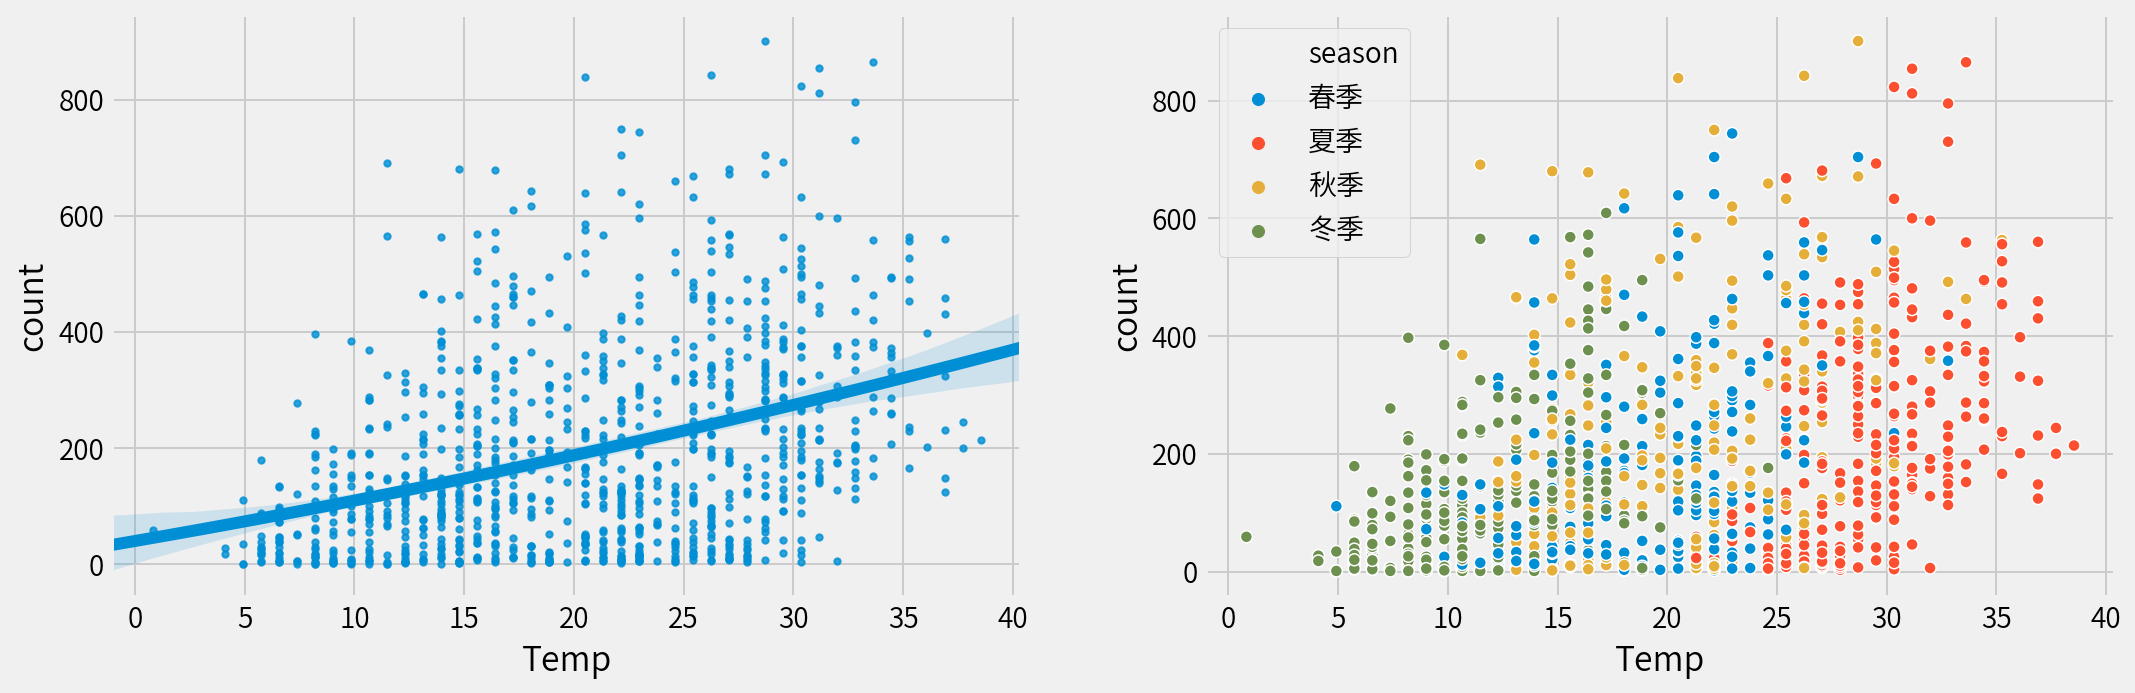

In [352]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1 = sns.regplot(data=sample1, x='temp', y='count', order=2, scatter_kws={"s": 10}, ax=ax1)
ax1.set_xlabel('Temp')
ax1.set_ylabel=('Hourly Bike Rental')

ax2 = sns.scatterplot(data=sample1, x='temp', y='count', hue='season', ax=ax2)

ax2.set_xlabel('Temp')
ax2.set_ylabel=('Hourly Bike Rental')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1000)

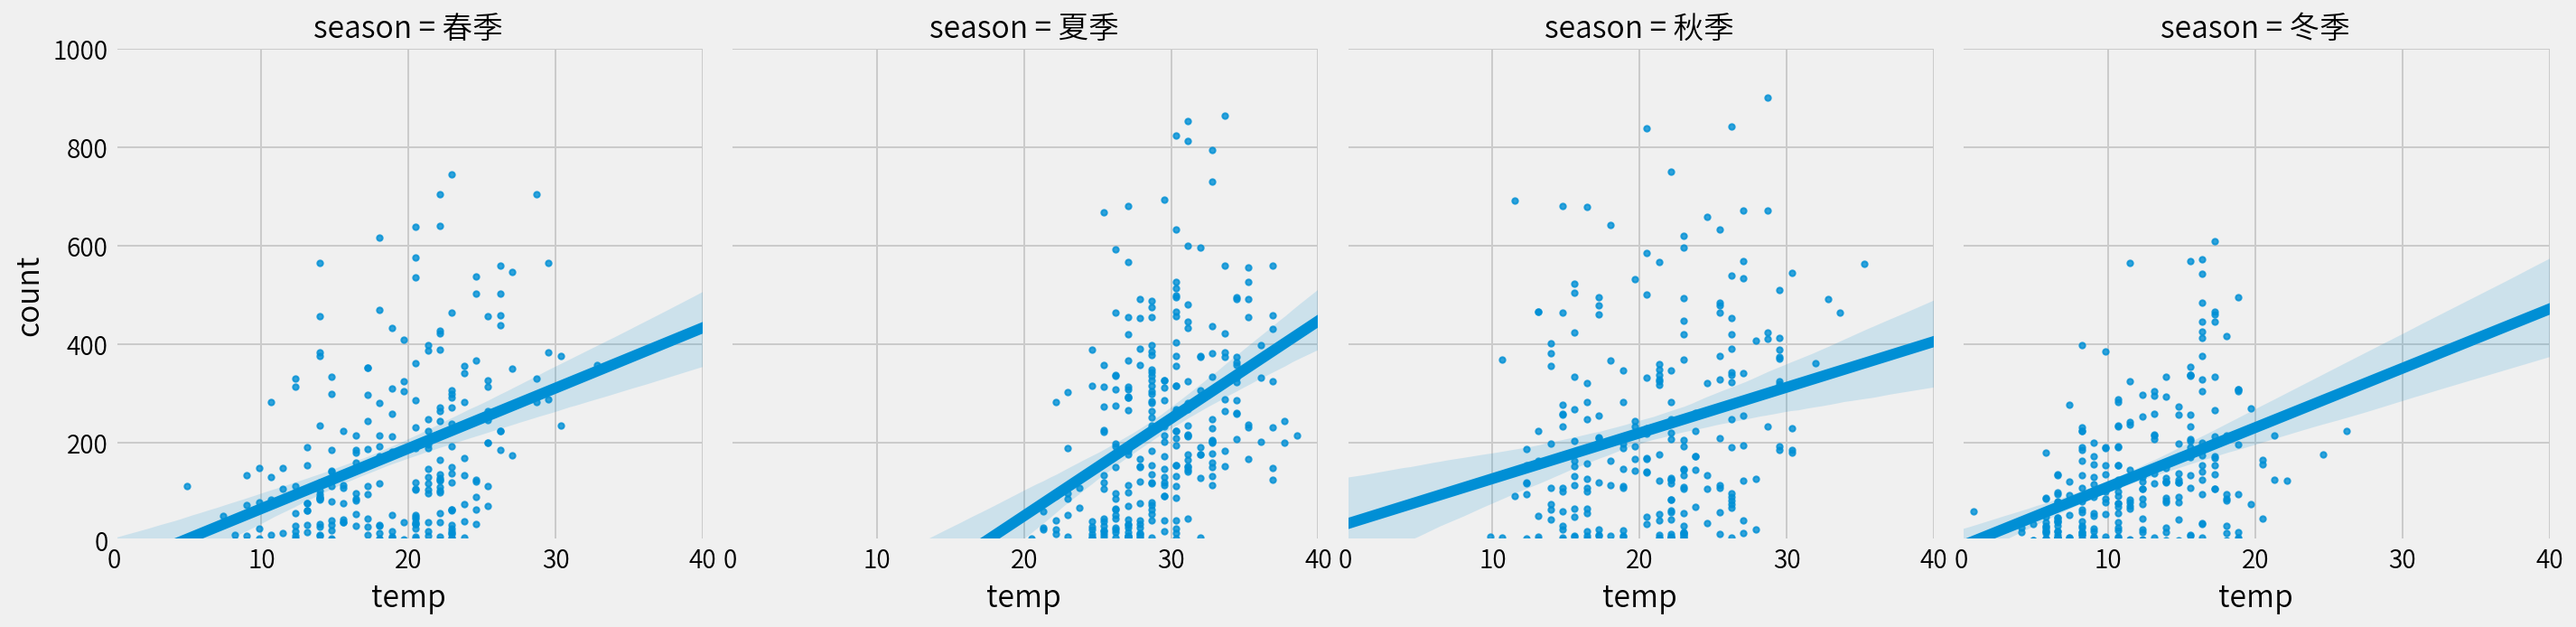

In [353]:
sns.lmplot(data=sample1, x='temp', y='count', col='season', scatter_kws={"s": 10})
plt.xlim(0,40)
plt.ylim(0,1000)

In [354]:
print(bike_rental.groupby('season')['temp'].mean().reset_index())
print('')
print(bike_rental.groupby('season')['count'].mean().reset_index())

  season       temp
0     春季  19.111543
1     夏季  29.214298
2     秋季  20.629110
3     冬季  11.843938

  season       count
0     春季  184.074210
1     夏季  237.158626
2     秋季  218.382644
3     冬季  125.753430


In [618]:
sample1 = bike_rental.sample(2000, random_state=42)

In [619]:
print(sample1.groupby('season')['temp'].mean())
print(sample1.groupby('season')['count'].mean())

season
Spring    12.401460
Summer    22.676727
Fall      28.704843
Winter    16.601746
Name: temp, dtype: float64
season
Spring    108.957404
Summer    215.070707
Fall      244.228346
Winter    195.825397
Name: count, dtype: float64


In [521]:
print(bike_rental.groupby('season')['humidity'].mean().reset_index())
print('')
print(bike_rental.groupby('season')['count'].mean().reset_index())

   season   humidity
0  Spring  56.297841
1  Summer  60.852909
2    Fall  64.123674
3  Winter  66.173738

   season       count
0  Spring  116.343261
1  Summer  215.251372
2    Fall  234.417124
3  Winter  198.988296


In [244]:
filter_data = bike_rental[bike_rental['windspeed'] > 40]
filter_data.head()

,year,month,day,hour,weekday,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_type
datetime,,,,,,,,,,,,,,,,,
2011-02-14 15:00:00,2011,2,14,15,Mon,Spring,0,1,1,22.96,26.515,21,43.9989,19,71,90,Workingday
2011-02-14 17:00:00,2011,2,14,17,Mon,Spring,0,1,1,18.86,22.725,33,40.9973,25,218,243,Workingday
2011-02-14 18:00:00,2011,2,14,18,Mon,Spring,0,1,1,16.40,20.455,40,40.9973,11,194,205,Workingday
2011-02-14 22:00:00,2011,2,14,22,Mon,Spring,0,1,1,13.94,14.395,46,43.9989,1,44,45,Workingday
2011-02-15 01:00:00,2011,2,15,1,Tue,Spring,0,1,1,12.30,12.120,42,51.9987,0,5,5,Workingday
